# CLASSIFICATION BASELINE

# 1 Import libraries

In [3]:
    #Basic
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import csv
import random
    #Imputing missing values
from sklearn.impute import SimpleImputer 
    #Changing names
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
    #Splitting database
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
    #Changing scales
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
    #Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
    #Hyperparameter optimization
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
    #Performance metrics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, recall_score
import scikitplot as skplt
import shap
import scipy.stats as stats

In [4]:
from utils.get_column import GetColumn

# 2 Load dataset

In [5]:
full_df = pd.read_csv('full_df.csv')

# 3 Feature selection

### For the classification baseline, we use the following features, based on the FRAX questionnaire: https://www.healthcentral.com/condition/osteoporosis/frax-score 

In [6]:
df = full_df[[
    'SEQN', # Participant ID
    'RIAGENDR', # Gender: 1=Male, 2=Female. https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DEMO_H.htm#RIAGENDR
    'RIDAGEYR', # Age (years). Individuals 80 and over are topcoded at 80 years of age. https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DEMO_H.htm#RIDAGEYR
    'BMXWT', # Weight (kg). https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/BMX_H.htm#BMXWT
    'BMXHT', # Height (cm). https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/BMX_H.htm#BMXHT
    'OSQ010A', # Ever fractured a hip. https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/OSQ_H.htm#OSQ010a
    'OSQ010B', # Ever fractured a wrist. https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/OSQ_H.htm#OSQ010b
    'OSQ010C', # Ever fractured spine. https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/OSQ_H.htm#OSQ010c
    'OSQ080', # Doctor ever told any other fractures? https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/OSQ_H.htm#OSQ080
    'OSQ170', # Did mother ever fracture hip? https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/OSQ_H.htm#OSQ170
    'OSQ200', # Did father ever fracture hip? https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/OSQ_H.htm#OSQ200
    'ALQ130', # Avg number of alcoholic drinks/day in the past 12 months. https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/ALQ_H.htm#ALQ130
    'SMD650', # Avg number of cigarettes/day during past 30 days. https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/SMQ_H.htm#SMD650
    'OSQ130', # Ever taken prednisone or cortisone daily. https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/OSQ_H.htm#OSQ130
    'MCQ160A', # Doctor ever said you had arthritis. https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/MCQ_H.htm#MCQ160a
    'DIQ010', # Doctor told you have diabetes. https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/DIQ_H.htm#DIQ010
    #'RHQ031', # WOMEN ONLY. Had regular periods in past 12 months. https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/RHQ_H.htm#RHQ031
    'TARGET_BINARY' # 1: Low Bone Density, 0: Healthy
]]

#multicursor

In [7]:
#c = GetColumn({
#    '':'SEQN',
#    '':'RIAGENDR',
#    '':'RIDAGEYR',
#    '':'BMXWT',
#    '':'BMXHT',
#    '':'OSQ010A',
#    '':'OSQ010B',
#    '':'OSQ010C',
#    '':'OSQ080',
#    '':'OSQ170',
#    '':'OSQ200',
#    '':'ALQ130',
#    '':'SMD650',
#    '':'OSQ130',
#    '':'MCQ160A',
#    '':'DIQ010',
#    #'': 'RHQ031
#    '':'TARGET_BINARY'
#})

# 4 Data exploration

In [8]:
df.head()

,SEQN,RIAGENDR,RIDAGEYR,BMXWT,BMXHT,OSQ010A,OSQ010B,OSQ010C,OSQ080,OSQ170,OSQ200,ALQ130,SMD650,OSQ130,MCQ160A,DIQ010,TARGET_BINARY
0,73557.0,1.0,69.0,78.3,171.3,2.0,2.0,2.0,2.0,2.0,NaN,1.0,NaN,2.0,1.0,1.0,NaN
1,73558.0,1.0,54.0,89.5,176.8,2.0,2.0,2.0,2.0,2.0,2.0,4.0,1.0,2.0,2.0,1.0,0.0
2,73559.0,1.0,72.0,88.9,175.3,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,2.0,2.0,1.0,NaN
3,73560.0,1.0,9.0,32.2,137.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN
4,73561.0,2.0,73.0,52.0,162.4,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,1.0,1.0,2.0,1.0


In [9]:
df.describe()

,SEQN,RIAGENDR,RIDAGEYR,BMXWT,BMXHT,OSQ010A,OSQ010B,OSQ010C,OSQ080,OSQ170,OSQ200,ALQ130,SMD650,OSQ130,MCQ160A,DIQ010,TARGET_BINARY
count,9823.000000,9823.000000,9823.000000,9399.000000,8750.000000,3463.000000,3461.000000,3461.000000,3461.000000,3341.000000,3304.000000,3468.000000,1238.000000,3446.000000,5405.000000,9411.000000,2897.000000
mean,78634.850046,1.507075,29.745597,62.260081,155.640050,1.983540,1.916787,1.980064,1.762785,1.930859,1.976998,2.728662,10.420840,1.945154,1.755967,1.947296,0.386607
std,2936.063484,0.499975,23.030712,32.711359,23.475604,0.127254,0.276244,0.139802,0.425436,0.253732,0.149934,2.388782,8.432323,0.227713,0.429552,0.293366,0.487056
min,73557.000000,1.000000,0.000000,3.100000,79.700000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,76088.500000,1.000000,9.000000,35.900000,149.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,4.000000,2.000000,2.000000,2.000000,0.000000
50%,78635.000000,2.000000,24.000000,65.000000,162.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,10.000000,2.000000,2.000000,2.000000,0.000000
75%,81172.500000,2.000000,49.000000,83.600000,171.100000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,15.000000,2.000000,2.000000,2.000000,1.000000
max,83731.000000,2.000000,79.000000,222.600000,202.600000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,25.000000,90.000000,2.000000,2.000000,3.000000,1.000000


# 5 Missing values

In [10]:
df.isna().sum()

SEQN                0
RIAGENDR            0
RIDAGEYR            0
BMXWT             424
BMXHT            1073
OSQ010A          6360
OSQ010B          6362
OSQ010C          6362
OSQ080           6362
OSQ170           6482
OSQ200           6519
ALQ130           6355
SMD650           8585
OSQ130           6377
MCQ160A          4418
DIQ010            412
TARGET_BINARY    6926
dtype: int64

Drop participants that have no target variable

In [11]:
df=df.dropna(subset=['TARGET_BINARY'])

In [12]:
df.isna().sum()

SEQN                0
RIAGENDR            0
RIDAGEYR            0
BMXWT              17
BMXHT              18
OSQ010A             0
OSQ010B             0
OSQ010C             2
OSQ080              2
OSQ170             96
OSQ200            128
ALQ130           1109
SMD650           2330
OSQ130             10
MCQ160A             9
DIQ010              1
TARGET_BINARY       0
dtype: int64

Drop participants in columns that have few missing values

In [13]:
df=df.dropna(subset=['BMXWT','BMXHT','OSQ010C','OSQ080','OSQ130','MCQ160A','DIQ010'])

In [14]:
df.isna().sum()

SEQN                0
RIAGENDR            0
RIDAGEYR            0
BMXWT               0
BMXHT               0
OSQ010A             0
OSQ010B             0
OSQ010C             0
OSQ080              0
OSQ170             94
OSQ200            123
ALQ130           1085
SMD650           2297
OSQ130              0
MCQ160A             0
DIQ010              0
TARGET_BINARY       0
dtype: int64

Drop columns that have many missing values from the dataset

In [15]:
df=df.dropna(axis=1)

In [16]:
df.isna().sum()

SEQN             0
RIAGENDR         0
RIDAGEYR         0
BMXWT            0
BMXHT            0
OSQ010A          0
OSQ010B          0
OSQ010C          0
OSQ080           0
OSQ130           0
MCQ160A          0
DIQ010           0
TARGET_BINARY    0
dtype: int64

In this database, sometime the answers were 'Don't know' or 'Refused'. Should those be considered as NaN? Let's see how many of those we have in the dataset:

In [17]:
df.nunique()

SEQN             2853
RIAGENDR            2
RIDAGEYR           40
BMXWT             776
BMXHT             480
OSQ010A             2
OSQ010B             2
OSQ010C             2
OSQ080              2
OSQ130              2
MCQ160A             2
DIQ010              3
TARGET_BINARY       2
dtype: int64

In [18]:
for col in df.columns:
    if df[col].nunique() < 5:
        print(f"Column: {col}")
        print("Number of unique values:", df[col].nunique())
        print("Unique values and their counts:")
        print(df[col].value_counts())
        print('-'*40)  # Just for better visual separation

Column: RIAGENDR
Number of unique values: 2
Unique values and their counts:
2.0    1440
1.0    1413
Name: RIAGENDR, dtype: int64
----------------------------------------
Column: OSQ010A
Number of unique values: 2
Unique values and their counts:
2.0    2812
1.0      41
Name: OSQ010A, dtype: int64
----------------------------------------
Column: OSQ010B
Number of unique values: 2
Unique values and their counts:
2.0    2631
1.0     222
Name: OSQ010B, dtype: int64
----------------------------------------
Column: OSQ010C
Number of unique values: 2
Unique values and their counts:
2.0    2802
1.0      51
Name: OSQ010C, dtype: int64
----------------------------------------
Column: OSQ080
Number of unique values: 2
Unique values and their counts:
2.0    2183
1.0     670
Name: OSQ080, dtype: int64
----------------------------------------
Column: OSQ130
Number of unique values: 2
Unique values and their counts:
2.0    2710
1.0     143
Name: OSQ130, dtype: int64
-----------------------------------

# 6 Data visualization

The figure layout has changed to tight


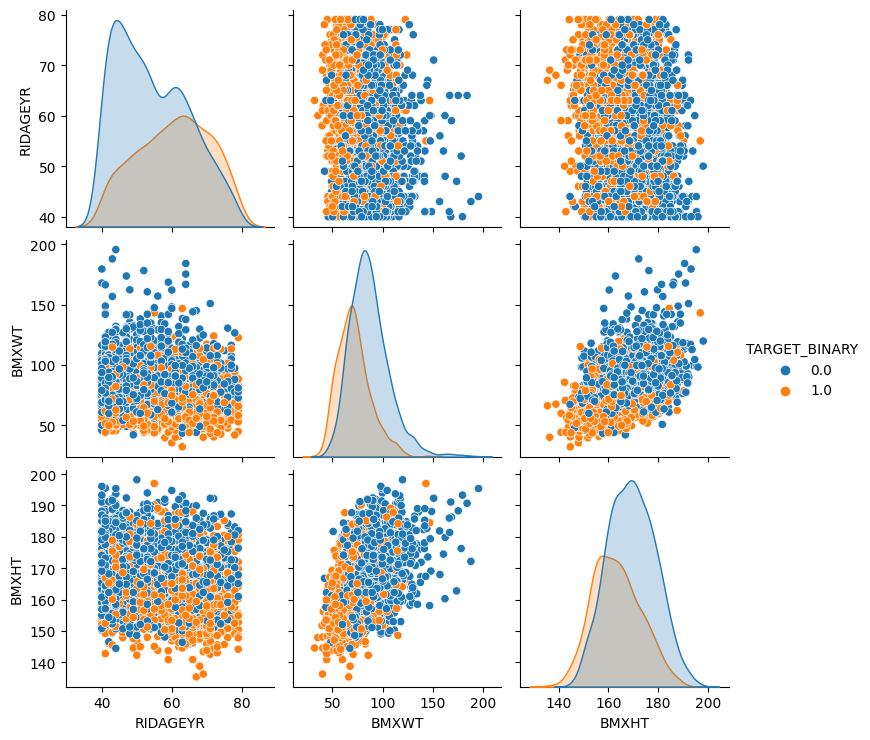

In [19]:
sns.pairplot(df[['RIDAGEYR','BMXWT','BMXHT','TARGET_BINARY']],hue='TARGET_BINARY')
plt.show()

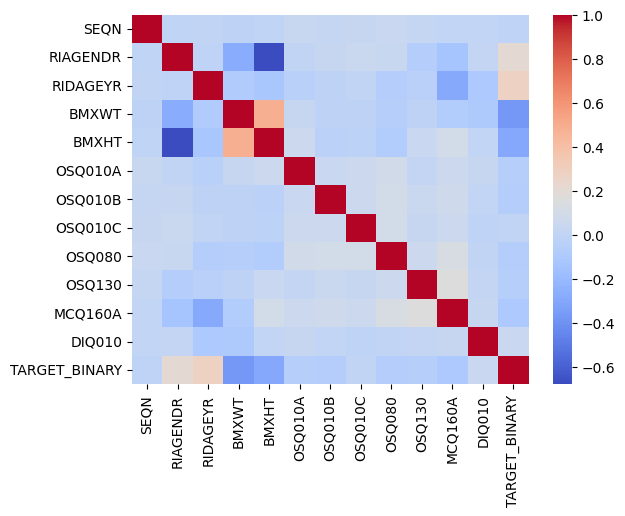

In [20]:
#Heatmap correlation

c=df.iloc[:,:].corr()
sns.heatmap(c,cmap='coolwarm')
plt.show()

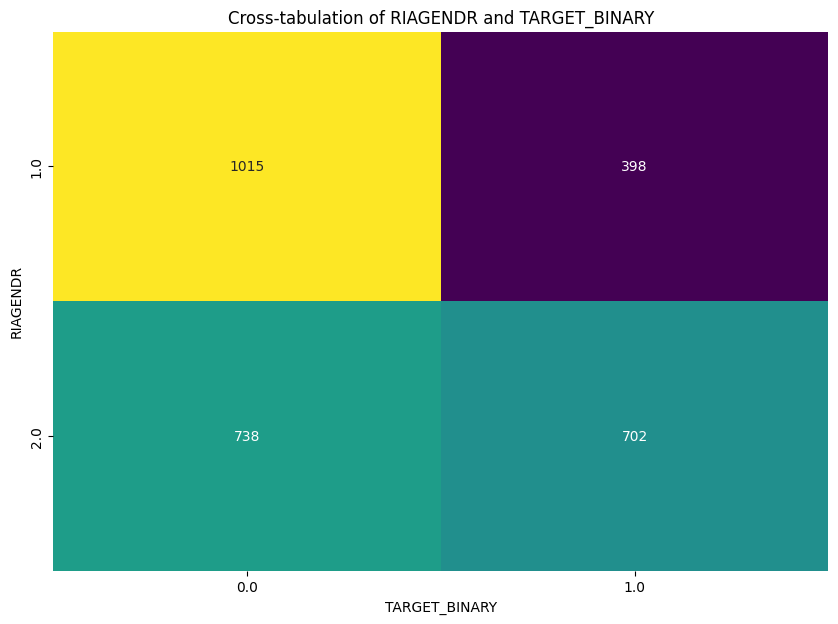

In [21]:
# Create cross-tabulation
cross_tab = pd.crosstab(df['RIAGENDR'], df['TARGET_BINARY'])

# Disable scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Plot
plt.figure(figsize=(10, 7))
sns.heatmap(cross_tab, annot=True, cmap='viridis', cbar=False, fmt='g')
plt.title("Cross-tabulation of RIAGENDR and TARGET_BINARY")
plt.show()

# 7 Split data into train and test sets

In [22]:
#X=df.iloc[:,1:-1].values # Exclusing Participant ID and TARGET_BINARY
X=df.iloc[:,1:-1] # Including columns names so that they are displayed in the feature importance plot
y=df['TARGET_BINARY'].values

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# 8 Scale normalization

In [24]:
# Instantiate an object of that class
scaler = StandardScaler() #MinMaxScaler() #RobustScaler() #MaxAbsScaler()

# Fit the transformer to the data (learning)
scaler.fit(X_train)

# Transform the data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Assign
#X_train = X_train_scaled
#X_test = X_test_scaled
X_train = pd.DataFrame(X_train_scaled, columns=X.columns) # Including columns names so that they are displayed in the feature importance plot
X_test = pd.DataFrame(X_test_scaled, columns=X.columns)

# 9 Models + Hyperparameter Optimization

### Decision tree

In [30]:
estimator = DecisionTreeClassifier()

# Define the hyperparameter grid
parameters={'max_depth': [4,6,8,10,12],
           'criterion': ['gini','entropy'],
           'splitter': ['best','random'],
           'min_weight_fraction_leaf': [0.0,0.1,0.2,0.3],
           'min_impurity_decrease': [0.0,0.05,0.1,0.2]}

# Create the GridSearchCV object
model = GridSearchCV(estimator=estimator,
                     param_grid=parameters,
                     cv=KFold(n_splits=10, shuffle=True, random_state=42),
                     verbose=1,
                     n_jobs=-1,
                     refit=True,
                     scoring='roc_auc')# Use threshold independent metrics! Recall is not a good a choice-->use ROC AUC instead (because dataset is balanced) or precision-recall curve AUC

# Fit the model
model.fit(X_train, y_train)

# Get the model parameters
print("Best parameters found: ")
print(model.best_estimator_)
print(model.best_params_)
print(f"Best roc_auc: %.1f%%"% (model.best_score_*100.0))

Fitting 10 folds for each of 320 candidates, totalling 3200 fits
Best parameters found: 
DecisionTreeClassifier(criterion='entropy', max_depth=4)
{'criterion': 'entropy', 'max_depth': 4, 'min_impurity_decrease': 0.0, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}
Best roc_auc: 76.0%


### SVC

In [39]:
# Define the SVC estimator
estimator = SVC(probability=True) #When you set probability=True for the SVC (Support Vector Machine Classifier) in scikit-learn, it enables the classifier to provide probability estimates for predictions. By default, SVMs do not directly provide probability estimates.

# Define the hyperparameter distribution
param_dist = {
    'C': stats.uniform(0.1, 10),  # Continuous uniform distribution between 0.1 and 10
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'] + list(stats.uniform(0.1, 1).rvs(1)),  # Adding some random gamma values
    'shrinking': [True, False],
    'degree': stats.randint(2, 5),  # Degree for 'poly' kernel. Integers between 2 and 5.
    'coef0': stats.uniform(0, 4),  # Uniform distribution between 0 and 4
}

# Create the RandomizedSearchCV object - MUY LENTO!!
model = RandomizedSearchCV(estimator=estimator,
                           param_distributions=param_dist,
                           n_iter=20,  # Number of parameter settings that are sampled. Increase if needed.
                           cv=KFold(n_splits=5, shuffle=True, random_state=42),  # Reducing to 5-fold CV for speed
                           verbose=1,
                           scoring='recall',
                           n_jobs=-1,
                           random_state=42,
                           refit=True)

# Fit the model
model.fit(X_train, y_train)

# Output the best parameters and score
print("Best parameters found: ", model.best_params_)
print("Best recall score: {:.2f}".format(model.best_score_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


### Random Forest Classifier

In [ ]:
# Define the RandomForestClassifier estimator
estimator = RandomForestClassifier()

# Define the hyperparameter grid
parameters = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at each leaf node
    'bootstrap': [True, False],  # Method of selecting samples for training each tree
    'criterion': ['gini', 'entropy']  # Function to measure the quality of a split
}

# Create the GridSearchCV object
model = GridSearchCV(estimator=estimator,
                     param_grid=parameters,
                     cv=KFold(n_splits=10, shuffle=True, random_state=42),
                     verbose=1,
                     scoring='recall',
                     n_jobs=-1,  # Use all available cores
                     refit=True)  # Refit the model with the best parameters found

# Fit the model
model.fit(X_train, y_train)

# Output the best parameters and score
print("Best parameters found: ", model.best_params_)
print("Best recall: {:.2f}".format(model.best_score_))

Fitting 10 folds for each of 432 candidates, totalling 4320 fits
Best parameters found:  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best recall: 0.58


### Logistic Regression

In [31]:
estimator = LogisticRegression()

# Define the hyperparameter grid
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.1, 1.0, 10.0],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 500, 1000],
    'l1_ratio': np.linspace(0, 1, 5)  # If using elasticnet
}

# Create the GridSearchCV object
model = GridSearchCV(estimator=estimator,
                     param_grid=parameters,
                     cv=KFold(n_splits=10, shuffle=True, random_state=42),
                     verbose=0,
                     scoring='roc_auc', #changing the scoring strategy
                     n_jobs=-1,
                     refit=True)

# Fit the model
model.fit(X_train, y_train)

# Get the model parameters
print("Best parameters found: ")
print(model.best_estimator_)
print(model.best_params_)
print(f"Best roc_auc: %.1f%%"% (model.best_score_*100.0))


Best parameters found: 
LogisticRegression(C=0.1, l1_ratio=0.5, max_iter=1000, solver='saga')
{'C': 0.1, 'l1_ratio': 0.5, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Best roc_auc: 78.6%



3600 fits failed out of a total of 9000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Horacio\OneDrive - UNIVERSIDAD DE SEVILLA\Doctorado\1 TRABAJOS ABIERTOS\26 Estudio Proyecto Samsung NHANES\nhanes_analysis\.environment\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Horacio\OneDrive - UNIVERSIDAD DE SEVILLA\Doctorado\1 TRABAJOS ABIERTOS\26 Estudio Proyecto Samsung NHANES\nhanes_analysis\.environment\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Horacio\OneD

### Naïve Bayes

In [ ]:
# Define the estimator
estimator = GaussianNB()

# Define the hyperparameter grid
parameters = {
    'var_smoothing': np.logspace(0,-9, num=100)  # Using a log scale for var_smoothing for a wider search range
}

# Create the GridSearchCV object
model = GridSearchCV(estimator=estimator,
                     param_grid=parameters,
                     cv=KFold(n_splits=10),
                     verbose=1,
                     scoring='recall',
                     n_jobs=-1,
                     refit=True)

# Fit the model
model.fit(X_train, y_train)

# Print the best hyperparameters
print("Best parameters:", model.best_params_)
print("Best recall score:", model.best_score_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best parameters: {'var_smoothing': 0.01519911082952933}
Best recall score: 0.4732168495037903


# 10 Testing performance

Some functions to report performance and explainability of the models

In [25]:
def metrics_score(actual, predicted):
    report = classification_report(actual, predicted, output_dict=True)
    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Normal', 'Osteo'], yticklabels=['Normal', 'Osteo'], cmap="Greens")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return report

In [26]:
def evaluate_overfitting(train_report: dict, test_report: dict, threshold=0.2) -> str:
    """
    Evaluate if a model is overfitting based on the performance metrics of the training and test sets.

    Parameters:
    - train_report (dict): Classification report for the training set.
    - test_report (dict): Classification report for the test set.
    - threshold (float): The acceptable difference in performance between the training and test sets.

    Returns:
    - str: A statement indicating if the model is likely overfitting.
    """
    
    # Extract weighted average f1-scores for training and test sets
    train_f1 = train_report['weighted avg']['f1-score']
    test_f1 = test_report['weighted avg']['f1-score']
    
    # Check if the difference in f1-scores exceeds the threshold
    if train_f1 - test_f1 > threshold:
        return "The model is likely overfitting."
    else:
        return "The model doesn't seem to be overfitting."


In [27]:
def do_shap(model, X_train):
    """
    Computes and visualizes SHAP values for a given model and training data.
    
    SHAP (SHapley Additive exPlanations) is a method to explain individual predictions. It assigns each feature 
    an importance value for a particular prediction. The magnitude of the SHAP value shows the strength of the 
    feature's effect. The sign of the SHAP value indicates whether the effect is positive or negative.

    Parameters:
    - model: The trained machine learning model for which we want to compute SHAP values.
    - X_train: The training data (DataFrame) used to train the model.

    Returns:
    None. But it will visualize a SHAP summary plot.
    """

    # 1. Get the appropriate SHAP explainer.

    # If the model is a tree-based model (Decision Tree or Random Forest)
    if isinstance(model, (DecisionTreeClassifier, RandomForestClassifier)):
        
        # Use TreeExplainer for tree-based models. It directly leverages the 
        # properties of trees to compute SHAP values efficiently.
        explainer = shap.TreeExplainer(model)
        
        # For tree-based models, we can use the entire training dataset without
        # performance issues.
        shap_data = X_train  

    # For models that are not tree-based (e.g., SVM, Logistic Regression)
    else:
        # We take a sample of the training data to speed up computation.
        # Using the full dataset with KernelExplainer can be computationally intensive.
        X_train_sampled = X_train.sample(100)
        
        # SHAP values are computed with respect to a "background" dataset. 
        # The background dataset helps in understanding feature interactions.
        # Here, we use k-means to summarize the sampled data into 10 representative 
        # clusters which will serve as the background dataset.
        background = shap.kmeans(X_train_sampled, 10)
        
        # KernelExplainer works for any model by approximating the model with 
        # a set of weighted linear functions. It's more computationally intensive 
        # than TreeExplainer.
        explainer = shap.KernelExplainer(model.predict, background)
        
        # Use the sampled dataset for non-tree models.
        shap_data = X_train_sampled  

    # 2. Compute SHAP values.
    # The SHAP values give us a measure of the impact of each feature on the 
    # model's predictions.
    shap_values = explainer.shap_values(shap_data)
    
    # 3. Visualize the impact of features on predictions.
    # The summary plot gives a bird's eye view of feature importance and what 
    # is driving it.
    shap.summary_plot(shap_values, shap_data, plot_type="bar")


In [28]:
# Define a function to plot the errors for different values of the input features
def plot_errors(X, y_true, y_pred, feature_names):
    for i, feature_name in enumerate(feature_names):
        plt.figure(figsize=(8, 6))
        plt.scatter(X[feature_name], y_true != y_pred, alpha=0.2)  # Change this line to use pandas-style indexing
        plt.xlabel(feature_name)
        plt.ylabel('Error')
        plt.title(f'Errors for {feature_name}')
        plt.show()

Let's delve into what this error analysis is doing and how it can be interpreted.

### **1. Objective of the `plot_errors` function**:

The `plot_errors` function visualizes how the errors of a model's predictions are distributed with respect to individual features. For each feature, the function generates a scatter plot where:

- The x-axis represents the values of that feature.
- The y-axis represents whether there was an error (1 for error, 0 for correct prediction).

### **2. How to interpret the scatter plots generated by the function**:

Each point on the scatter plot corresponds to an instance (i.e., a row of data from `X_test`). 

- If a point's y-value is `1`, that means the model made an incorrect prediction for that instance.
- If a point's y-value is `0`, it means the model made a correct prediction for that instance.

By looking at the scatter plots, you can understand:

1. **Feature Values Associated with Errors**: For certain values of a feature, you might see more errors (y=1) than for other values. For instance, if most errors for a feature appear when its value is greater than 10, it may indicate that the model has difficulty predicting correctly for those cases.

2. **Spread of Errors**: You can see if errors are scattered throughout the range of the feature or if they are concentrated in specific regions.

3. **Comparison Across Features**: Some features might show a clear pattern where errors are clustered, suggesting that the model is sensitive to changes in that feature or might not be capturing its relationship with the target variable accurately. On the other hand, some features might not show any discernible pattern in errors, suggesting that errors might not be strongly associated with variations in that particular feature.

### **3. Limitations and Further Investigations**:

- While this kind of plot can help understand how errors might be associated with feature values, it doesn't directly indicate why those errors are happening.
  
- The plots won't distinguish between false positives and false negatives. If that distinction is important, you may want to color the error points differently based on the type of error.

- If the dataset is large or the features have many unique values, the plots can become quite dense and difficult to interpret. In such cases, using histograms or density plots might be more appropriate.

- If you notice a strong pattern of errors with respect to a certain feature, you may consider further investigations, like checking if the feature has been correctly processed, if it has missing or outlier values, or if a different representation of the feature can help the model.

In summary, the `plot_errors` function offers a visual approach to understanding model errors in relation to individual features. It provides insights that can guide further refinements in feature engineering or model selection.

Training and evaluating the models (using the parameters found in the hyperparameter optimization step)

---------DecisionTreeClassifier---------

Recall: 73.2%
Cross-Validation Recall: 69.9% (6.5%)

                      TRAIN                       
              precision    recall  f1-score   support

         0.0       0.79      0.63      0.70      1402
         1.0       0.55      0.73      0.63       880

    accuracy                           0.67      2282
   macro avg       0.67      0.68      0.66      2282
weighted avg       0.70      0.67      0.67      2282



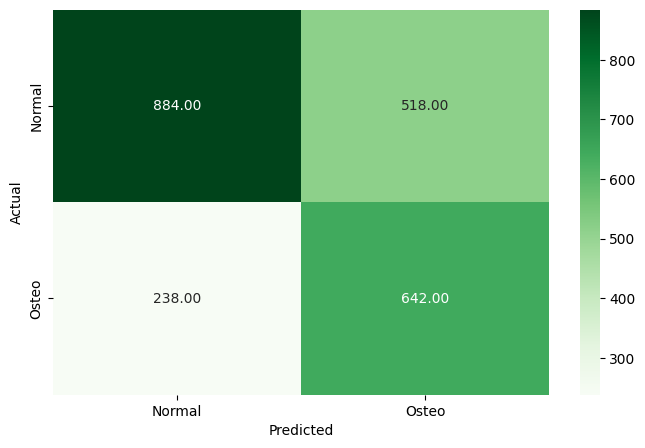

                       TEST                       
              precision    recall  f1-score   support

         0.0       0.79      0.65      0.71       351
         1.0       0.56      0.73      0.64       220

    accuracy                           0.68       571
   macro avg       0.68      0.69      0.68       571
weighted avg       0.71      0.68      0.68       571



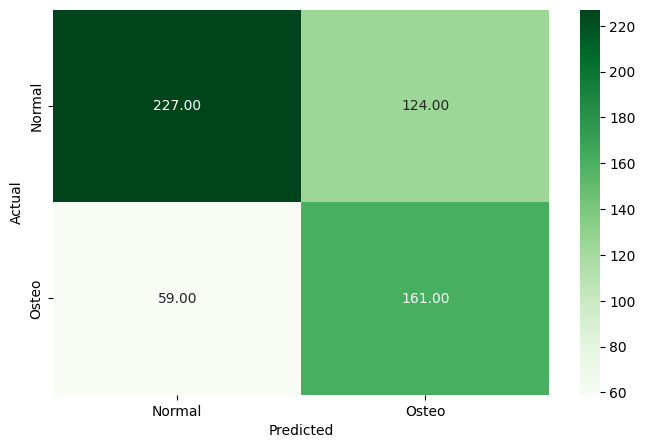

The model doesn't seem to be overfitting.



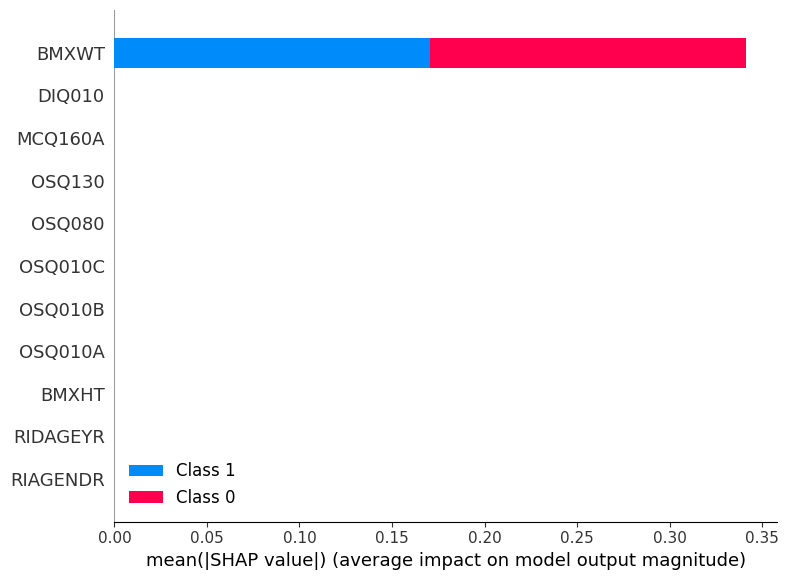

Feature ranking:
1. feature BMXWT (1.000000)
2. feature DIQ010 (0.000000)
3. feature MCQ160A (0.000000)
4. feature OSQ130 (0.000000)
5. feature OSQ080 (0.000000)
6. feature OSQ010C (0.000000)
7. feature OSQ010B (0.000000)
8. feature OSQ010A (0.000000)
9. feature BMXHT (0.000000)
10. feature RIDAGEYR (0.000000)
11. feature RIAGENDR (0.000000)


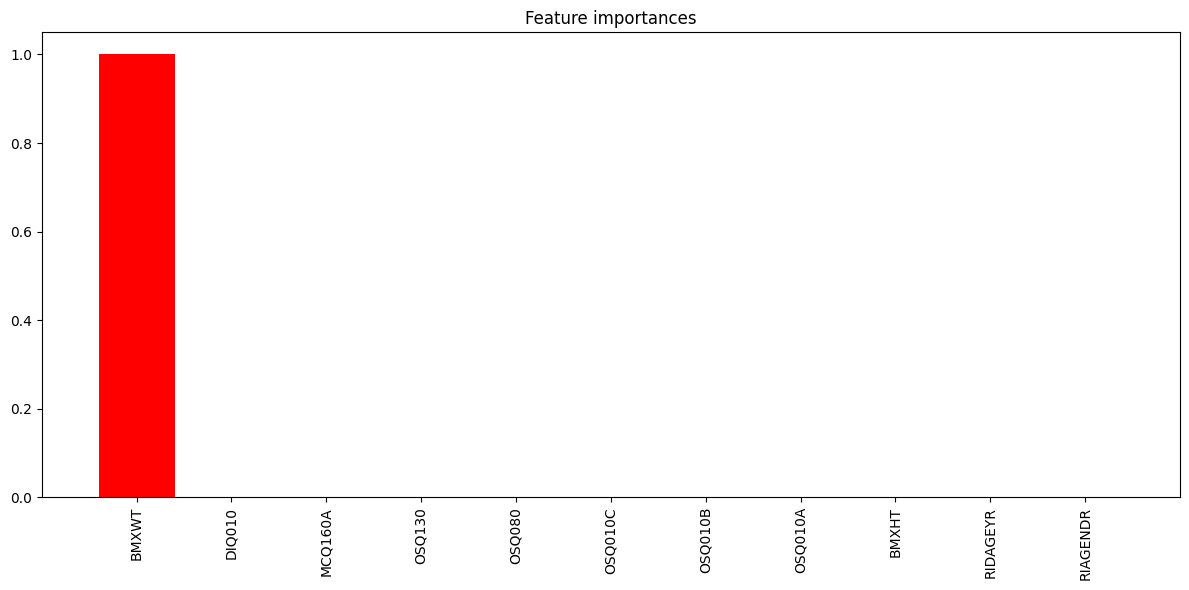

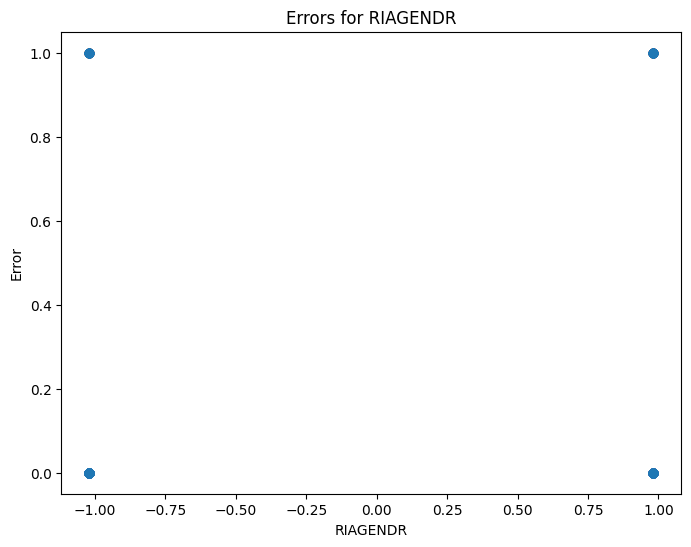

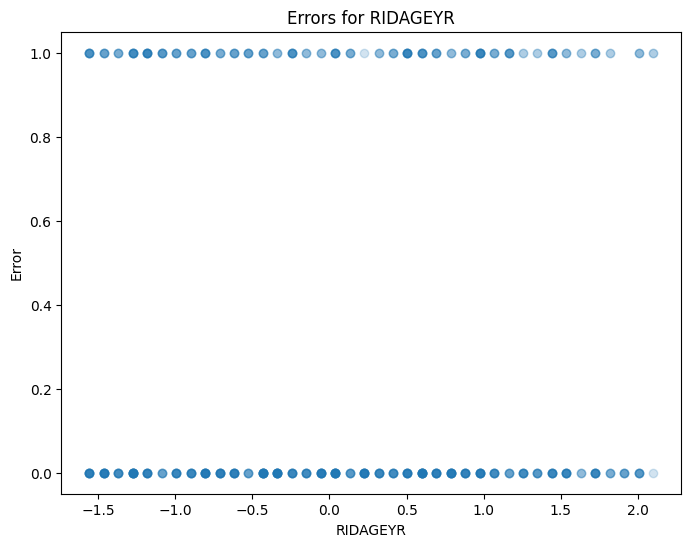

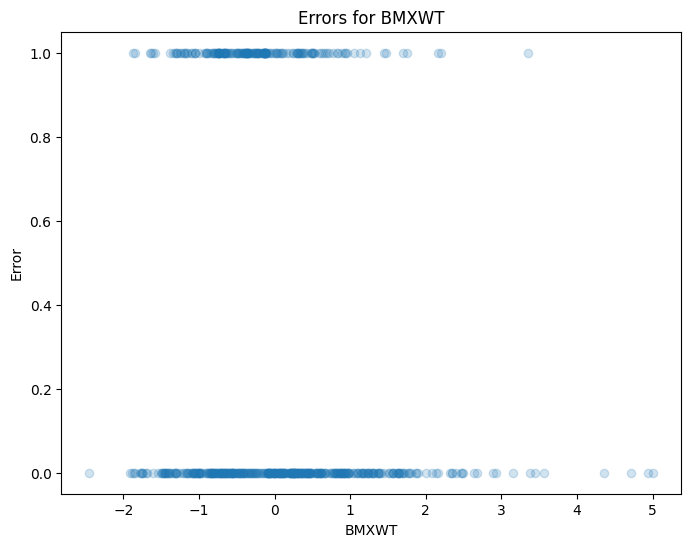

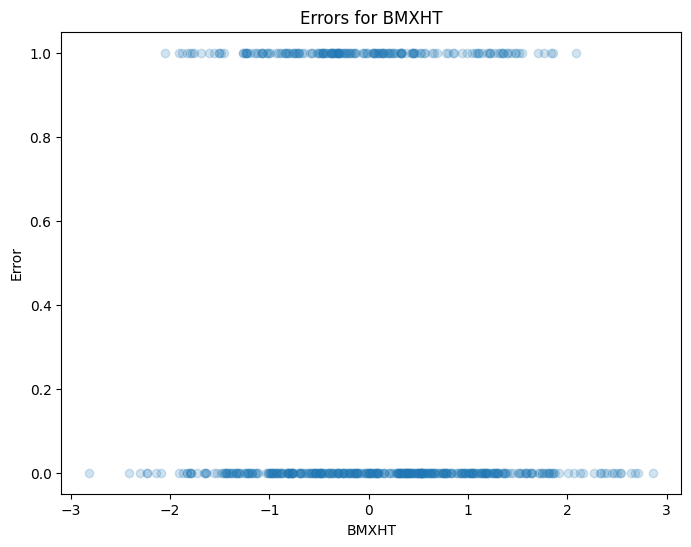

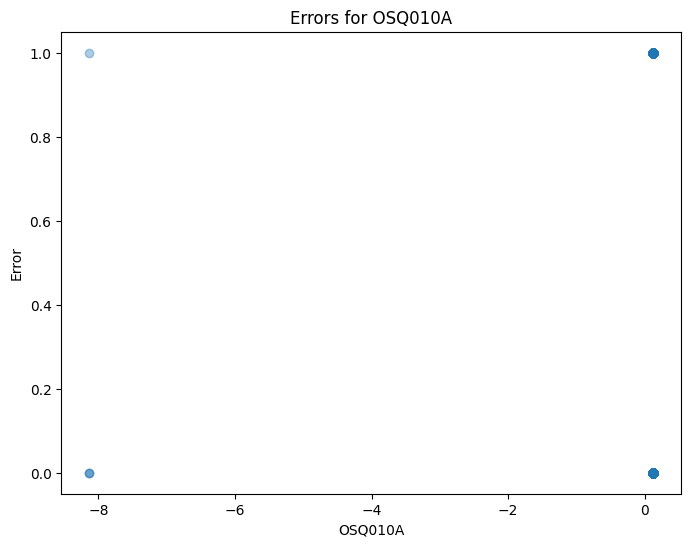

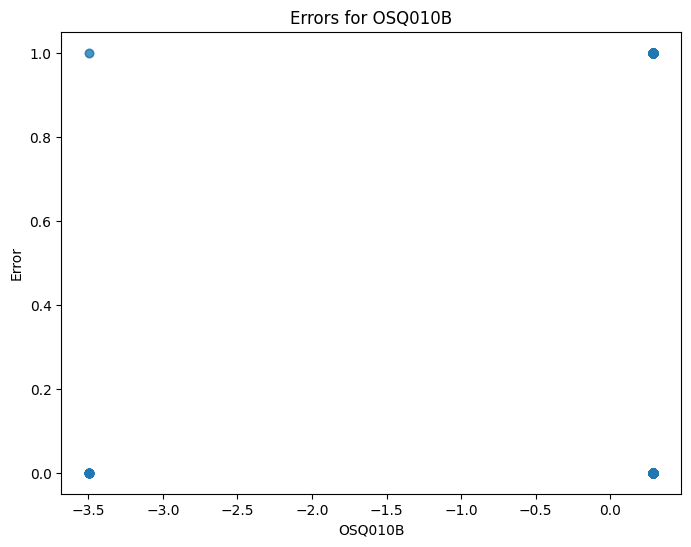

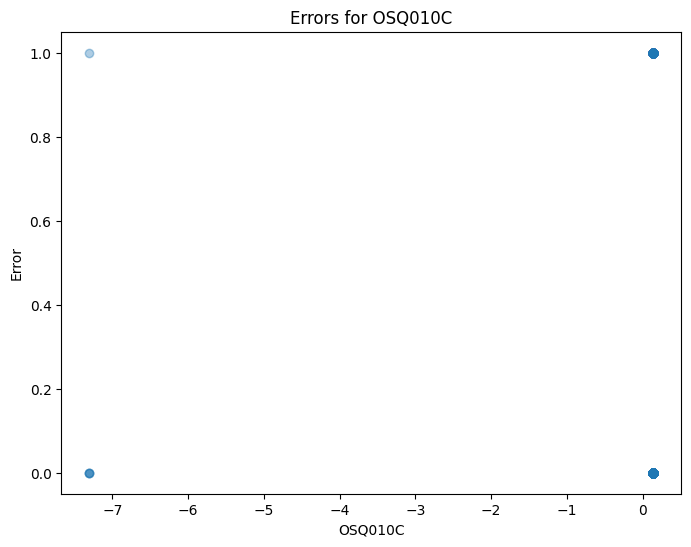

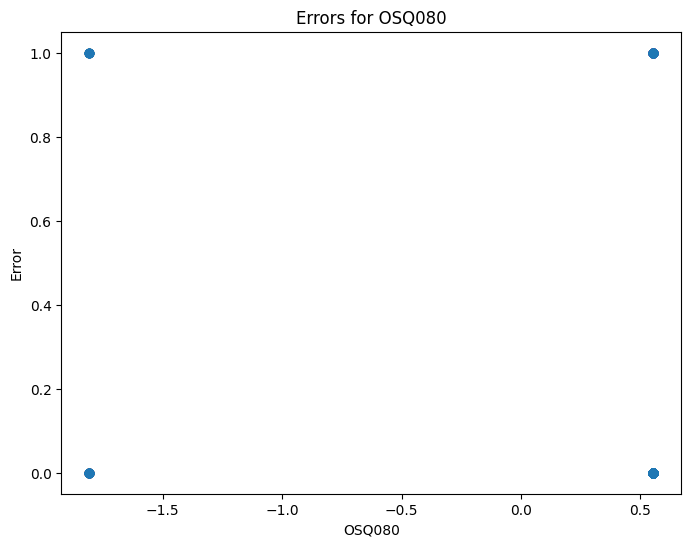

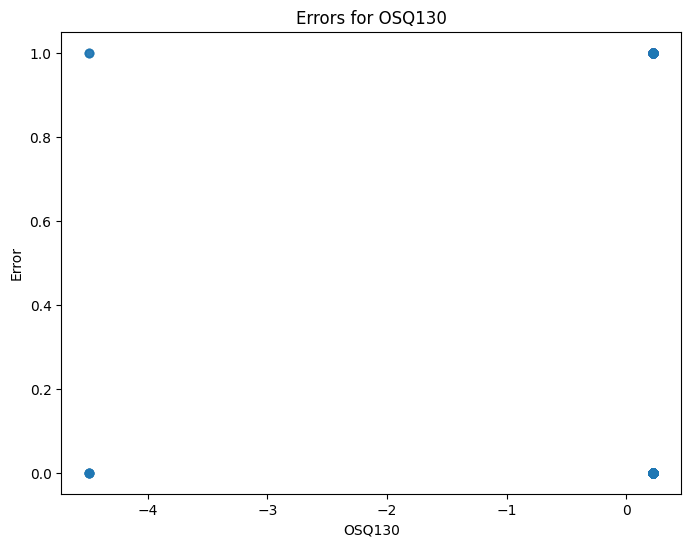

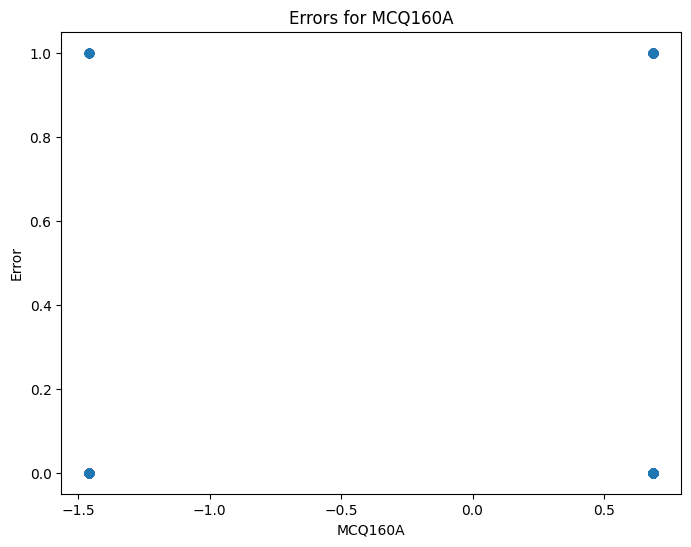

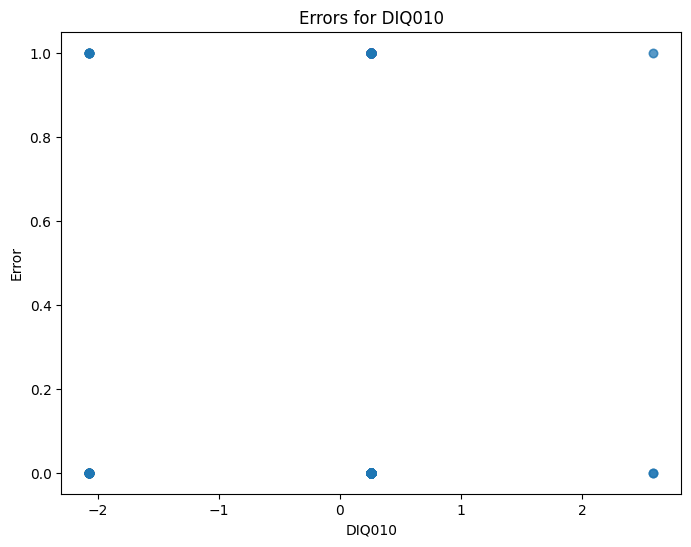


--------------------------------------------------------------------------------
---------RandomForestClassifier---------

Recall: 52.3%
Cross-Validation Recall: 53.9% (7.3%)

                      TRAIN                       
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1402
         1.0       1.00      1.00      1.00       880

    accuracy                           1.00      2282
   macro avg       1.00      1.00      1.00      2282
weighted avg       1.00      1.00      1.00      2282



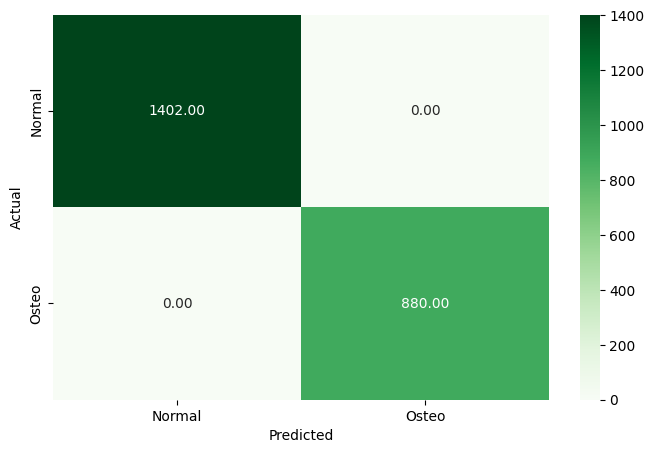

                       TEST                       
              precision    recall  f1-score   support

         0.0       0.72      0.78      0.75       351
         1.0       0.60      0.52      0.56       220

    accuracy                           0.68       571
   macro avg       0.66      0.65      0.66       571
weighted avg       0.68      0.68      0.68       571



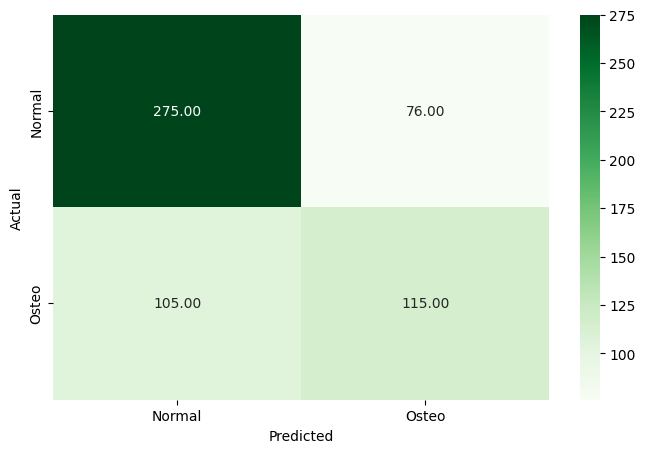

The model is likely overfitting.



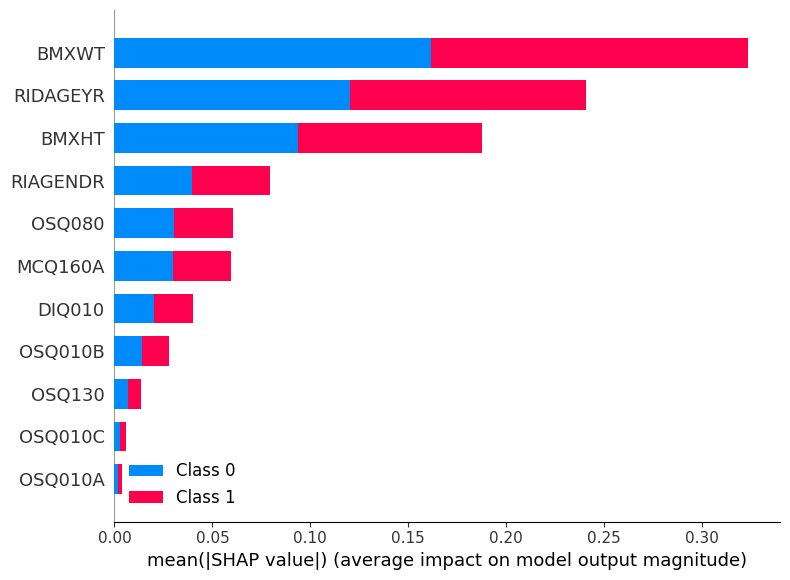

Feature ranking:
1. feature BMXWT (0.360187)
2. feature BMXHT (0.284050)
3. feature RIDAGEYR (0.220803)
4. feature DIQ010 (0.030511)
5. feature RIAGENDR (0.023225)
6. feature OSQ080 (0.020574)
7. feature MCQ160A (0.020263)
8. feature OSQ010B (0.016409)
9. feature OSQ130 (0.011960)
10. feature OSQ010C (0.008006)
11. feature OSQ010A (0.004014)


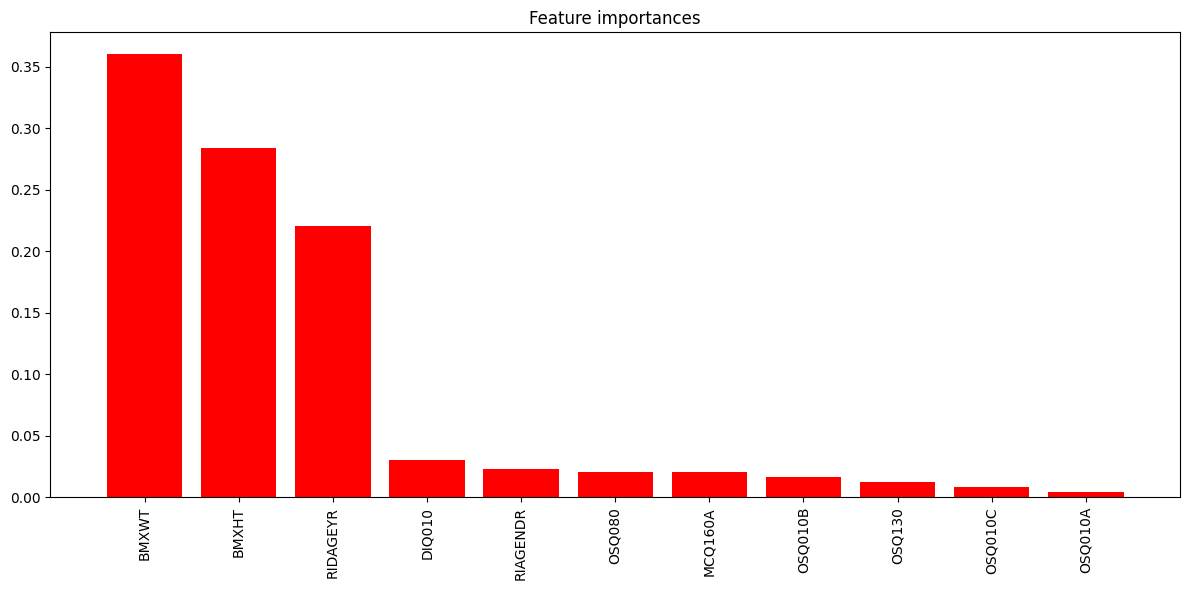

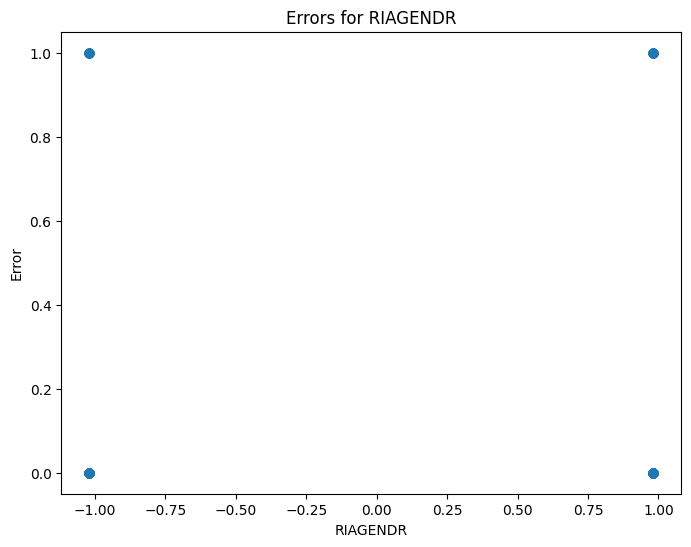

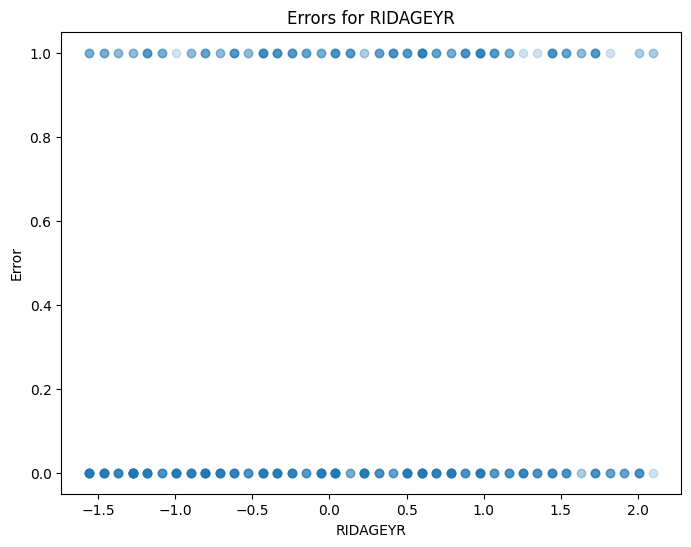

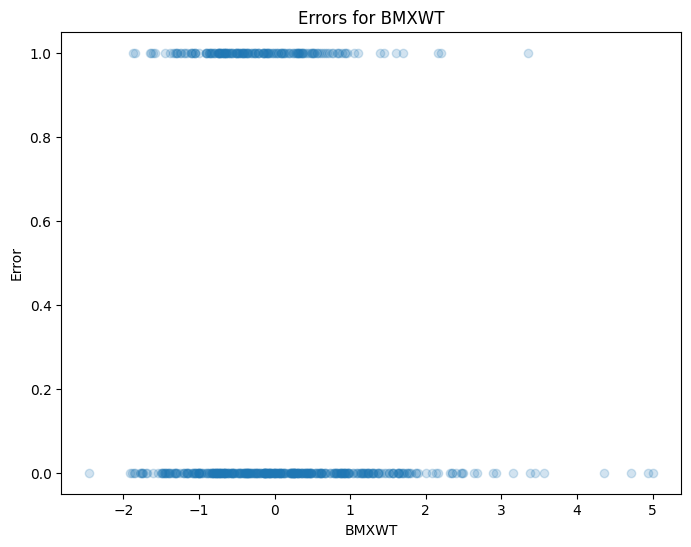

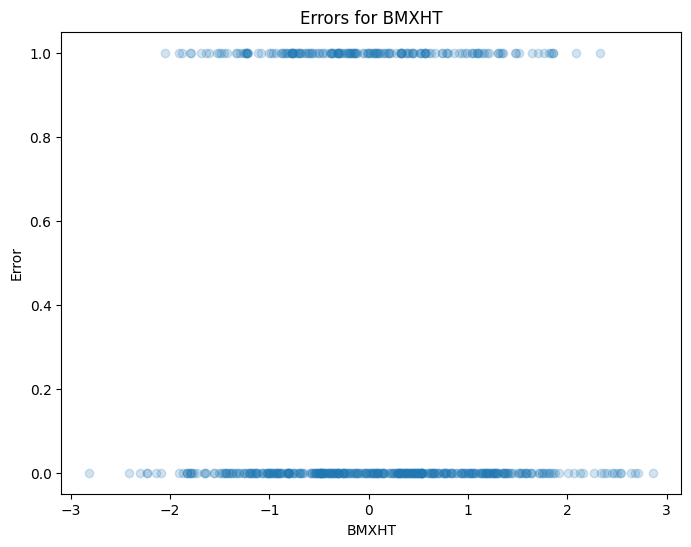

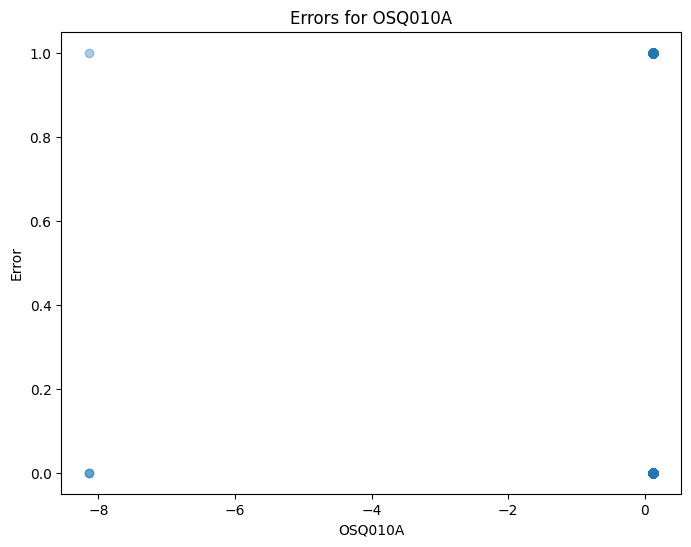

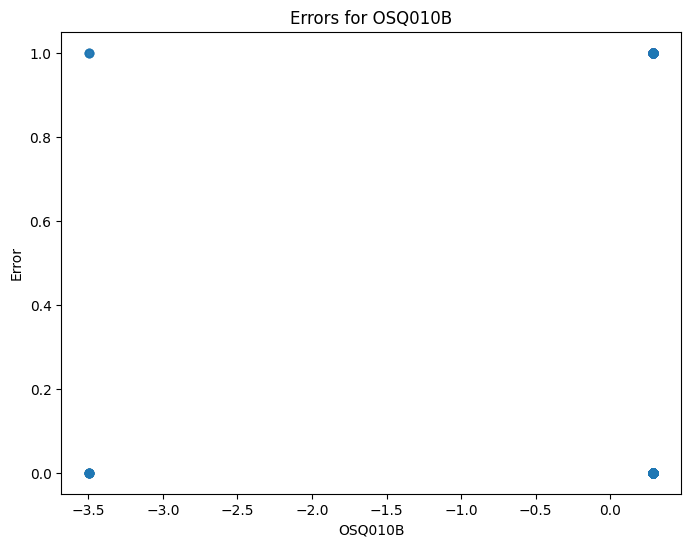

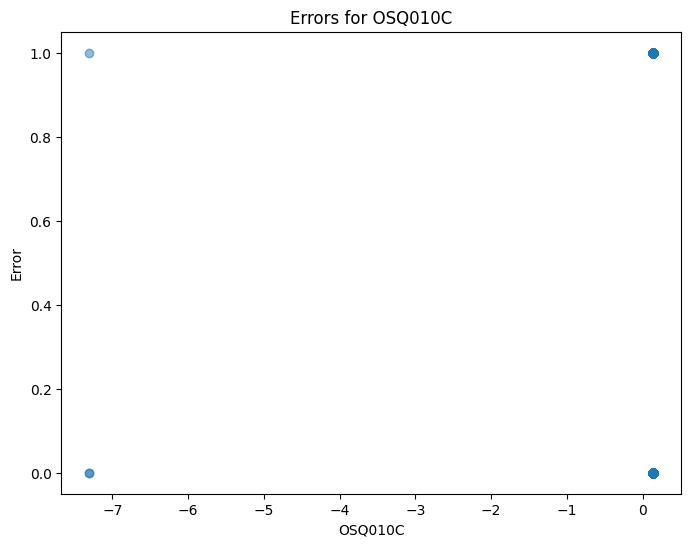

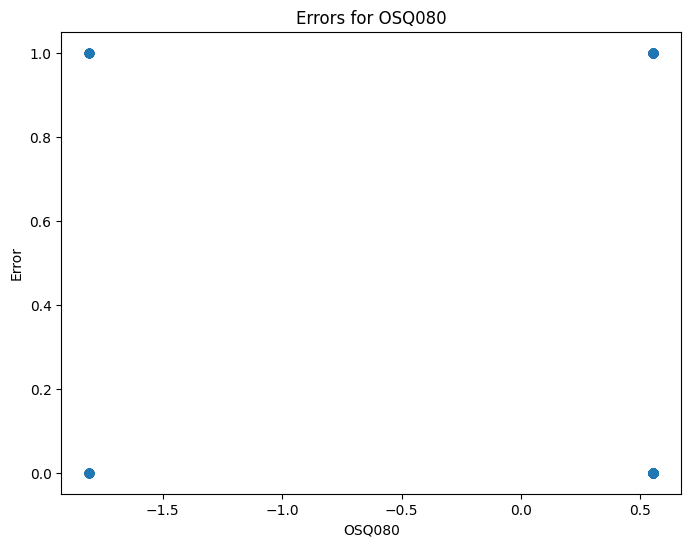

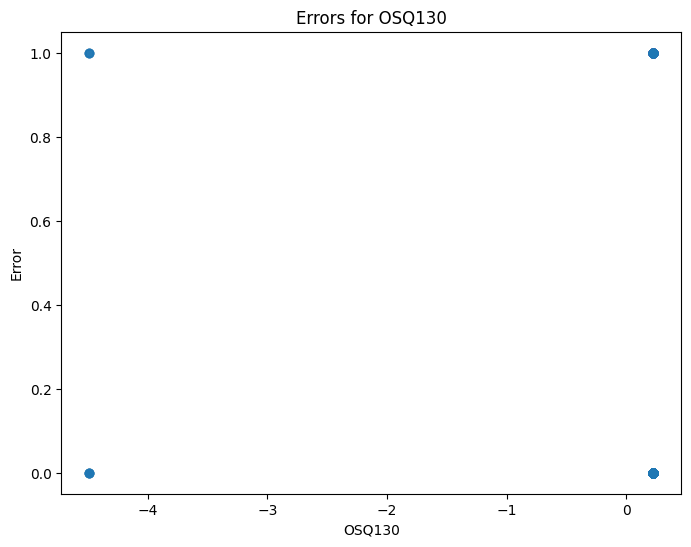

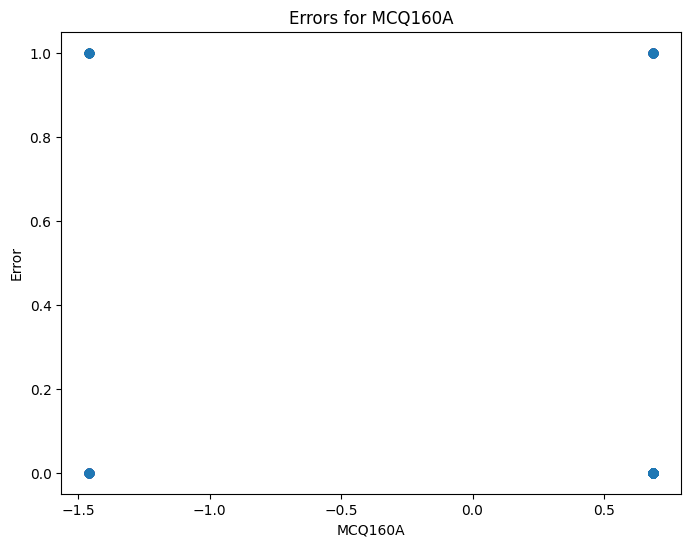

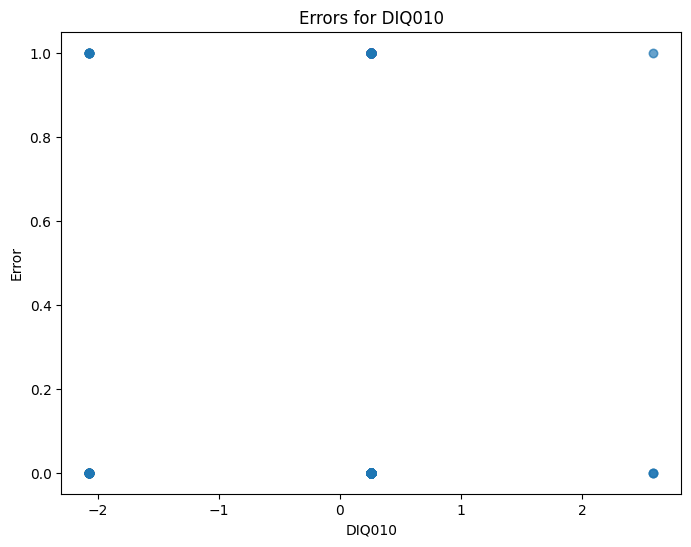


--------------------------------------------------------------------------------
------------------SVC-------------------

Recall: 58.6%
Cross-Validation Recall: 56.6% (4.8%)

                      TRAIN                       
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.81      1402
         1.0       0.71      0.58      0.64       880

    accuracy                           0.75      2282
   macro avg       0.74      0.72      0.72      2282
weighted avg       0.74      0.75      0.74      2282



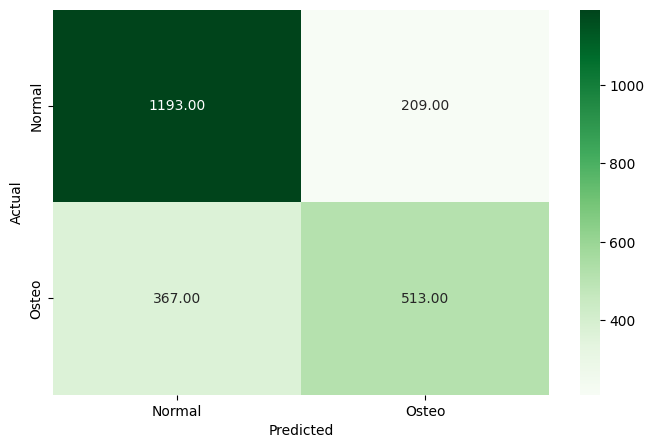

                       TEST                       
              precision    recall  f1-score   support

         0.0       0.76      0.82      0.79       351
         1.0       0.68      0.59      0.63       220

    accuracy                           0.73       571
   macro avg       0.72      0.70      0.71       571
weighted avg       0.73      0.73      0.73       571



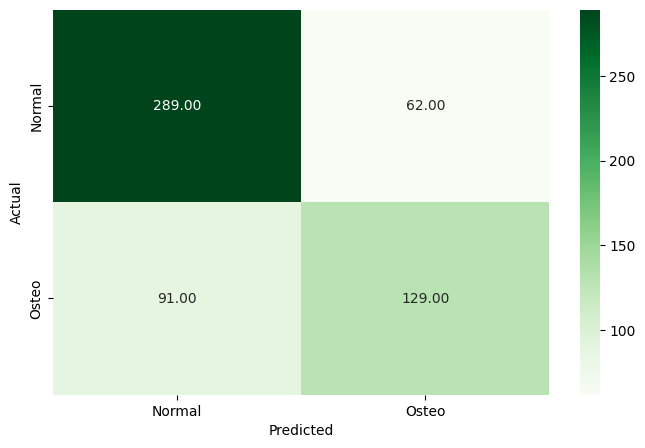

The model doesn't seem to be overfitting.



The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


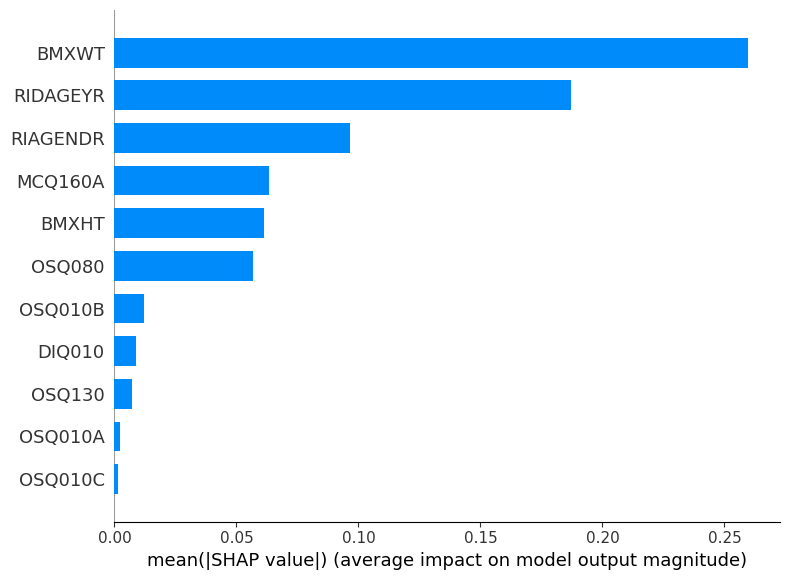

Feature ranking:
1. feature BMXWT (0.823739)
2. feature RIDAGEYR (0.529327)
3. feature RIAGENDR (0.232266)
4. feature OSQ080 (0.178419)
5. feature BMXHT (0.145393)
6. feature OSQ010B (0.127436)
7. feature MCQ160A (0.106003)
8. feature OSQ130 (0.057399)
9. feature DIQ010 (0.050273)
10. feature OSQ010A (0.037121)
11. feature OSQ010C (0.023696)


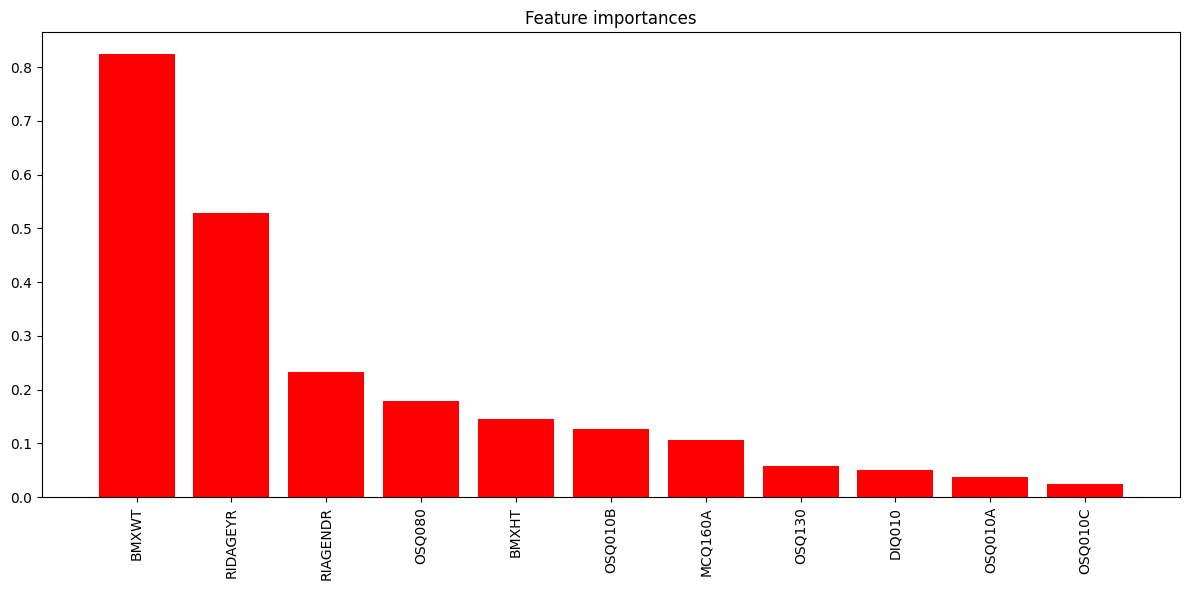

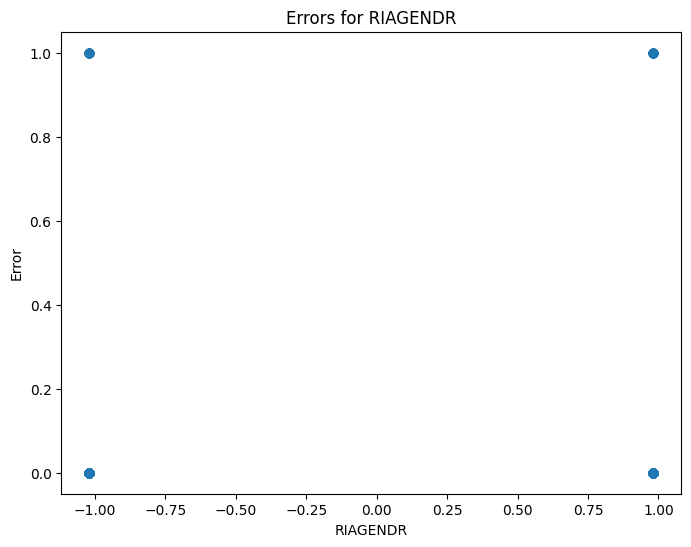

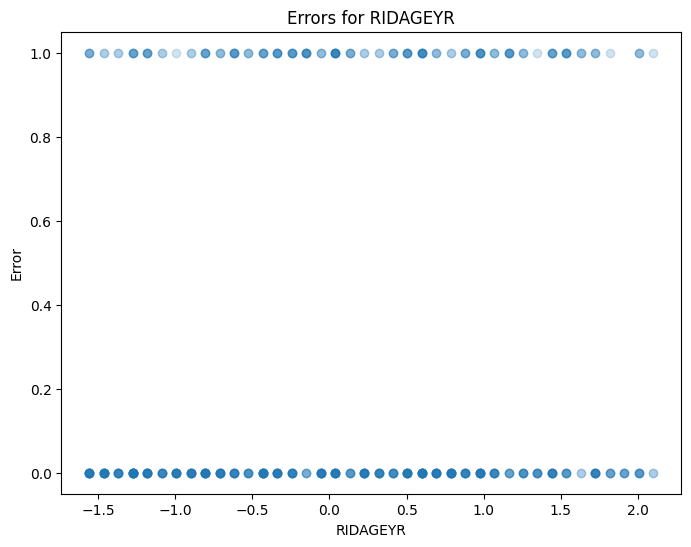

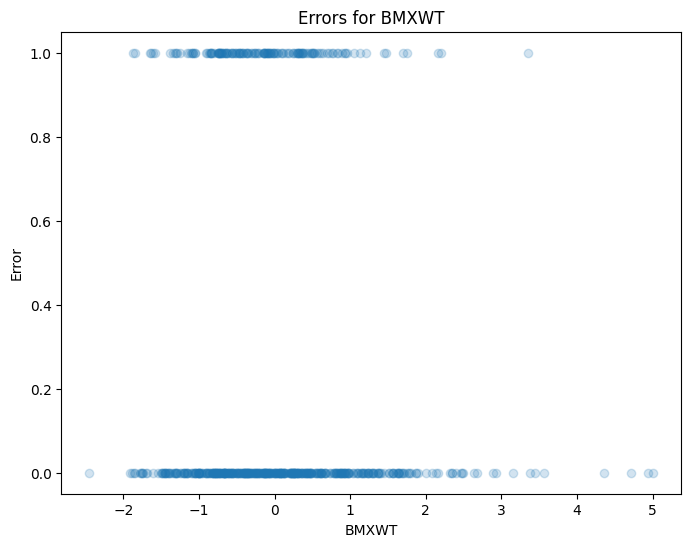

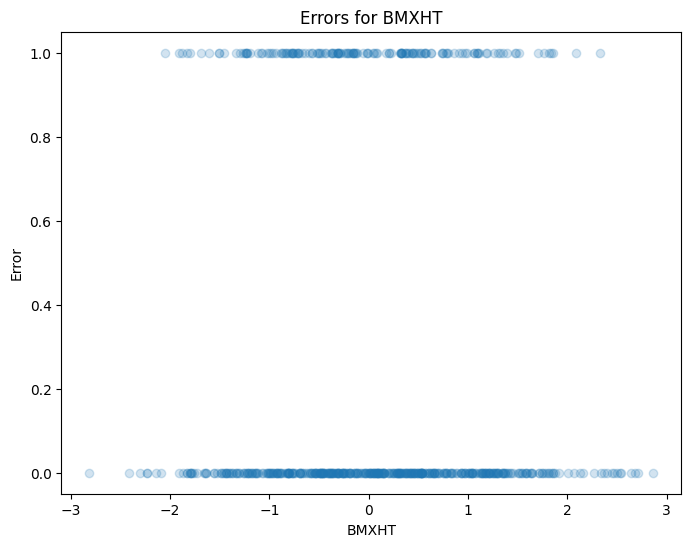

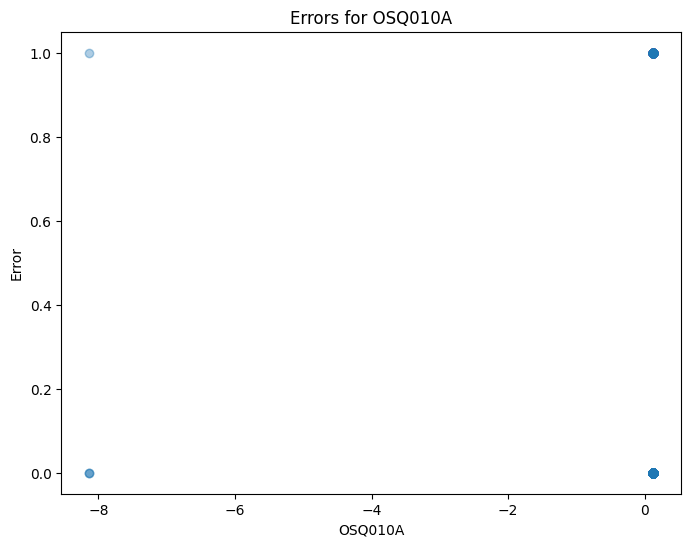

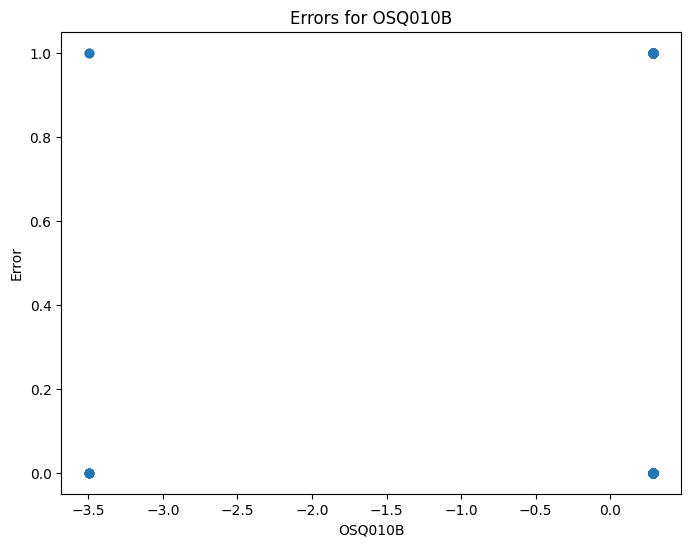

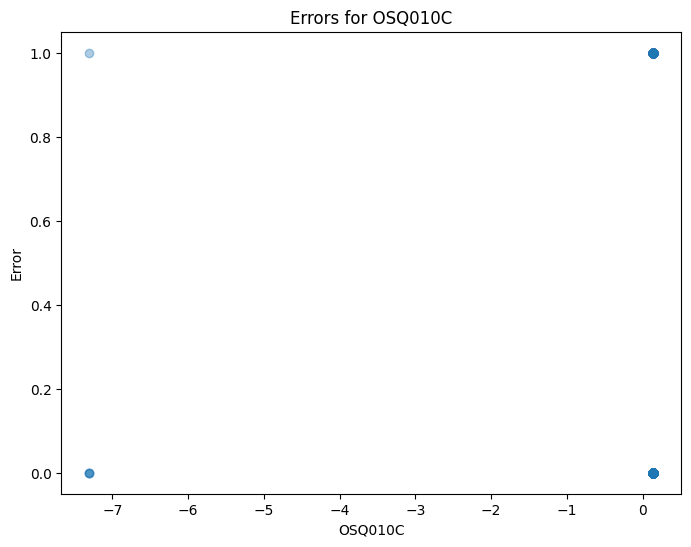

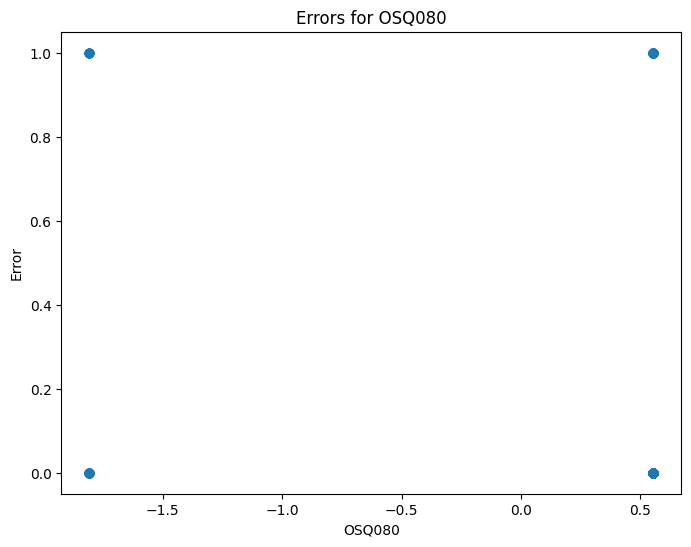

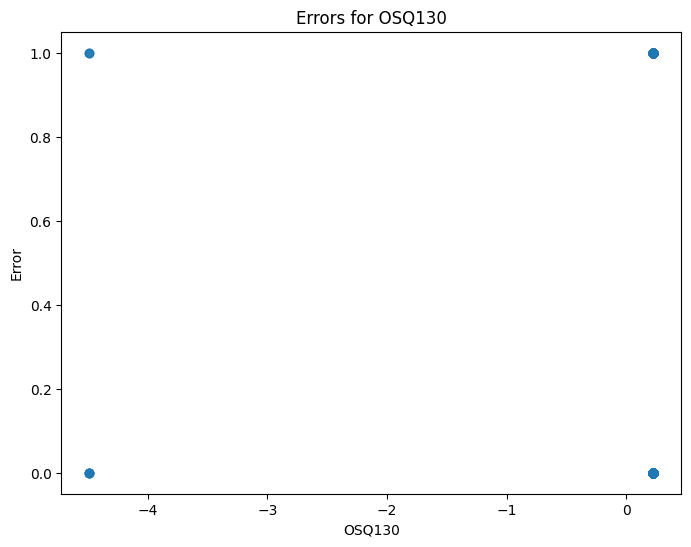

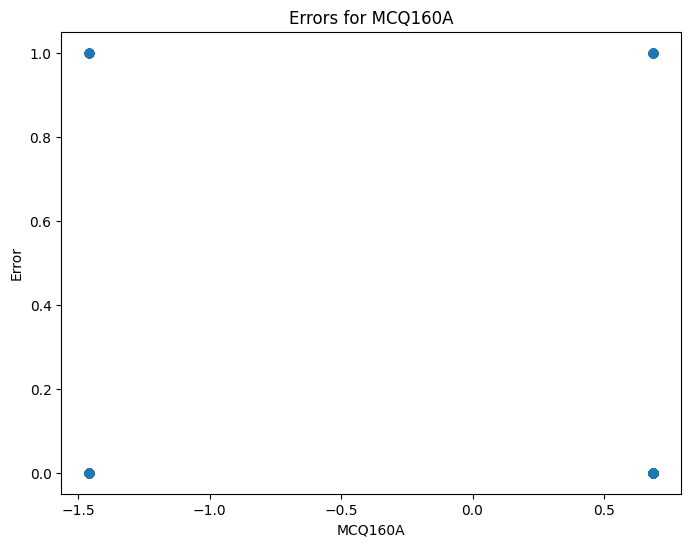

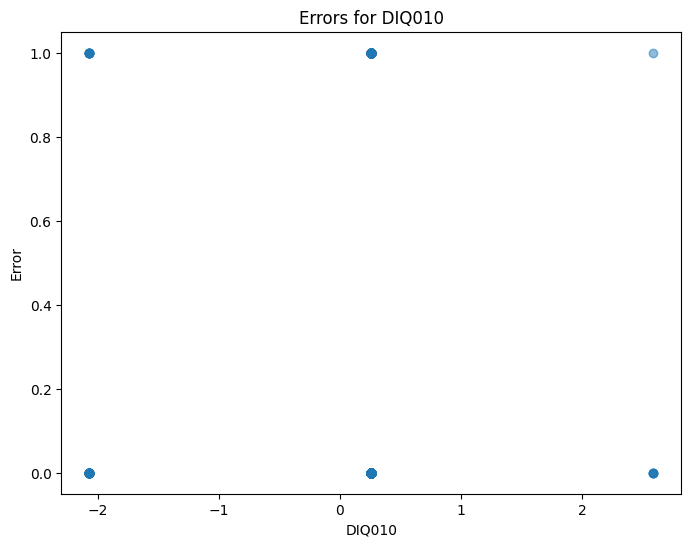


--------------------------------------------------------------------------------
-----------LogisticRegression-----------

Recall: 58.2%
Cross-Validation Recall: 58.3% (4.9%)

                      TRAIN                       
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80      1402
         1.0       0.70      0.58      0.64       880

    accuracy                           0.74      2282
   macro avg       0.73      0.71      0.72      2282
weighted avg       0.74      0.74      0.74      2282



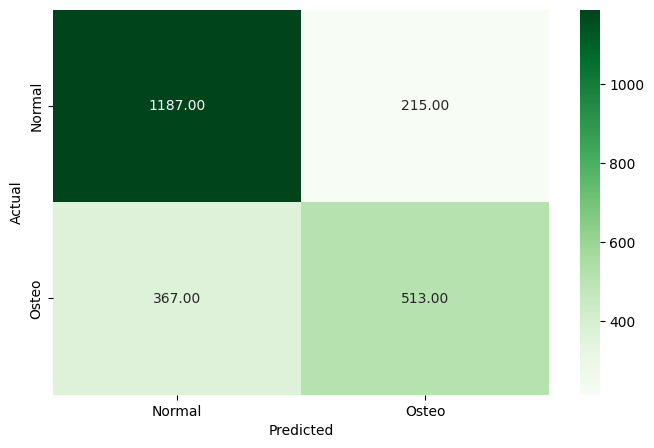

                       TEST                       
              precision    recall  f1-score   support

         0.0       0.76      0.82      0.79       351
         1.0       0.67      0.58      0.62       220

    accuracy                           0.73       571
   macro avg       0.71      0.70      0.70       571
weighted avg       0.72      0.73      0.72       571



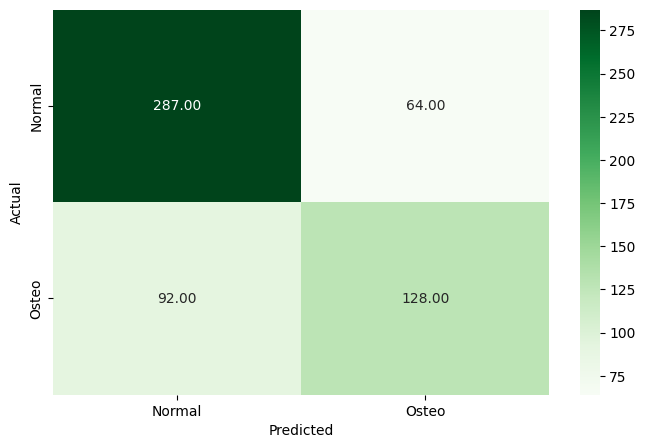

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


The model doesn't seem to be overfitting.



100%|██████████| 100/100 [00:07<00:00, 12.75it/s]


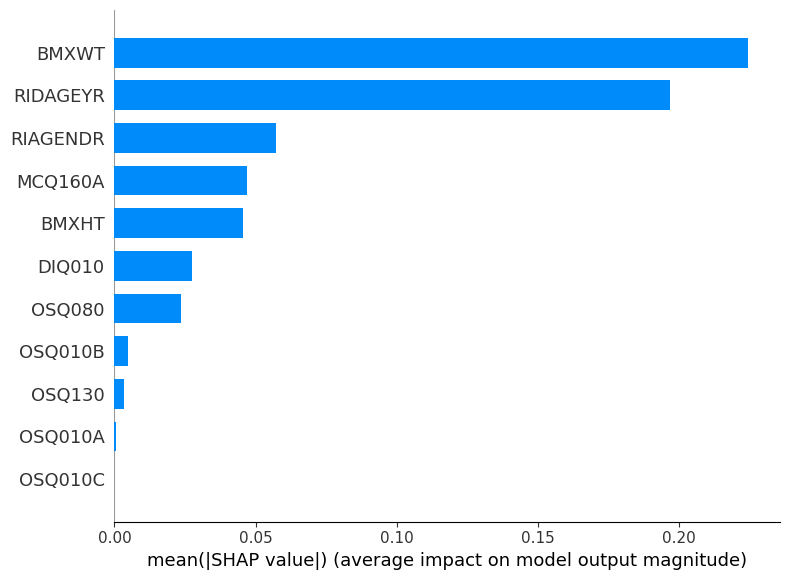

Feature ranking:
1. feature BMXWT (0.883229)
2. feature RIDAGEYR (0.566481)
3. feature RIAGENDR (0.196567)
4. feature OSQ080 (0.157073)
5. feature BMXHT (0.153819)
6. feature OSQ010B (0.133612)
7. feature DIQ010 (0.083650)
8. feature MCQ160A (0.076061)
9. feature OSQ130 (0.056657)
10. feature OSQ010A (0.026378)
11. feature OSQ010C (0.000000)


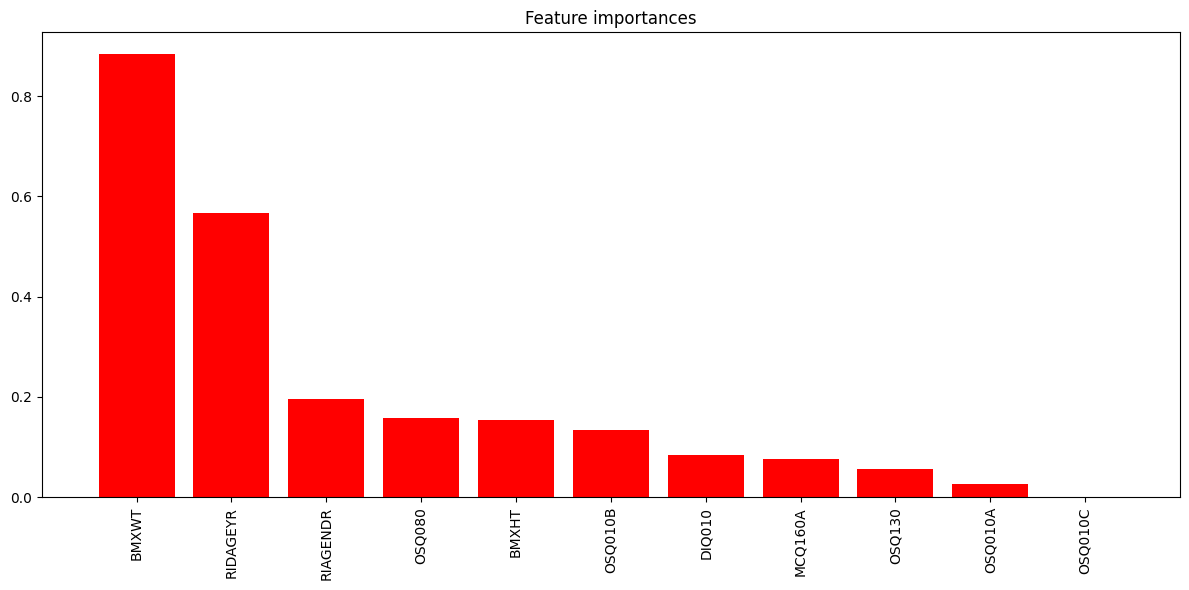

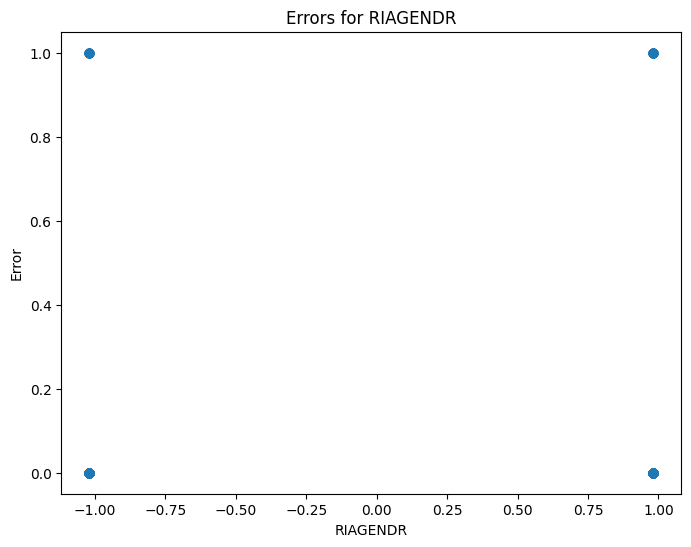

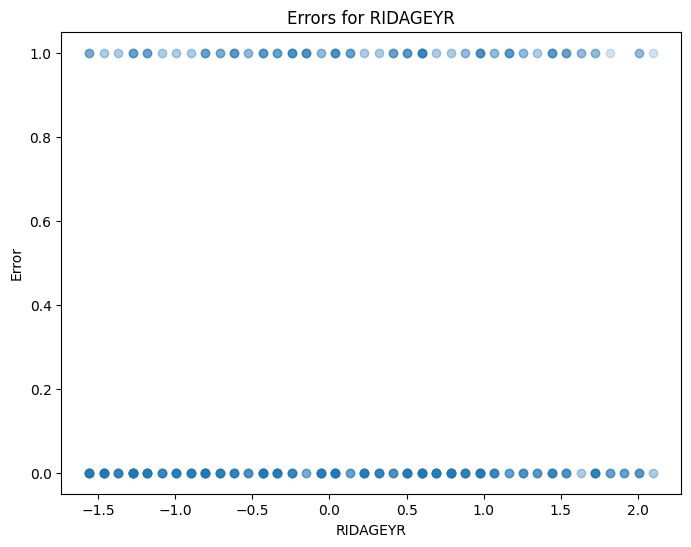

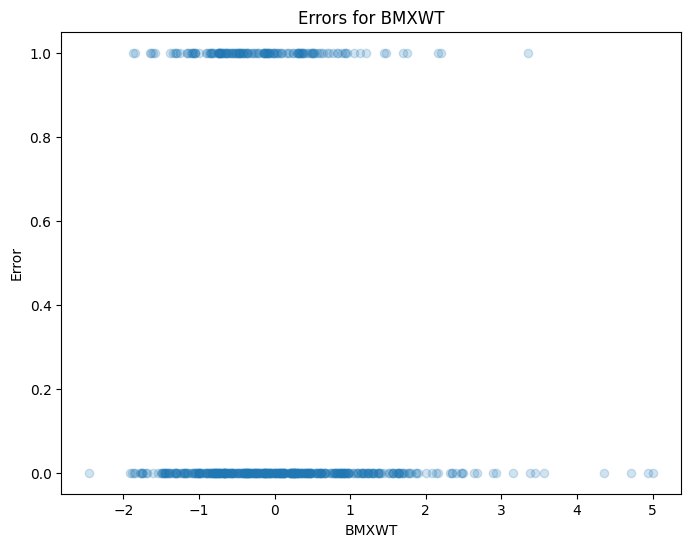

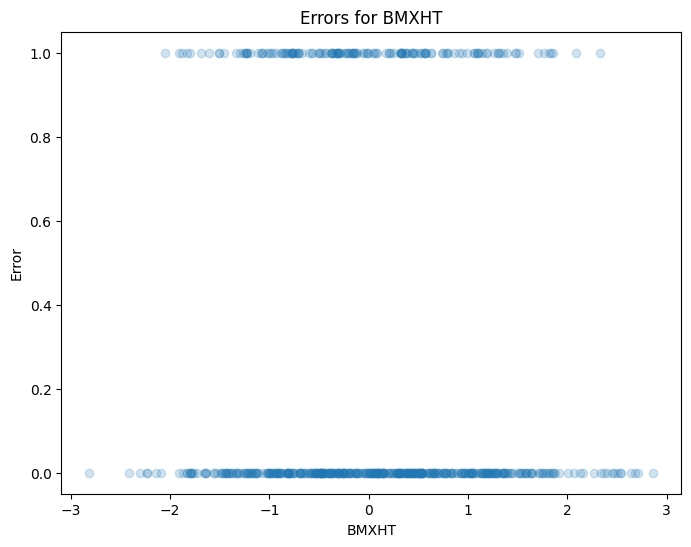

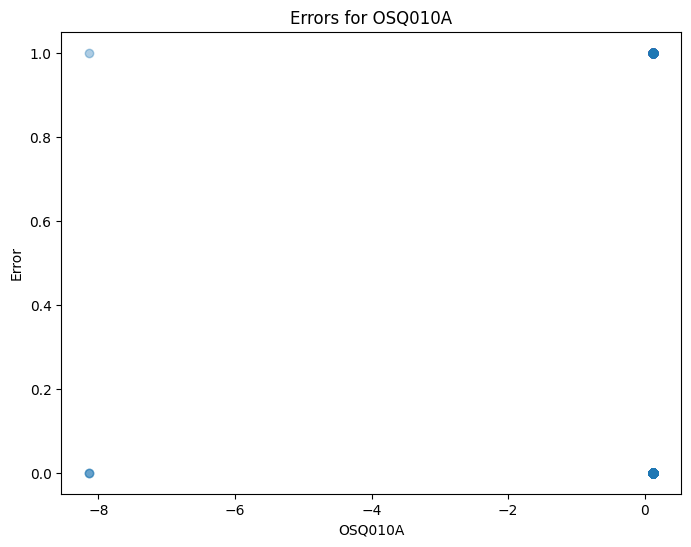

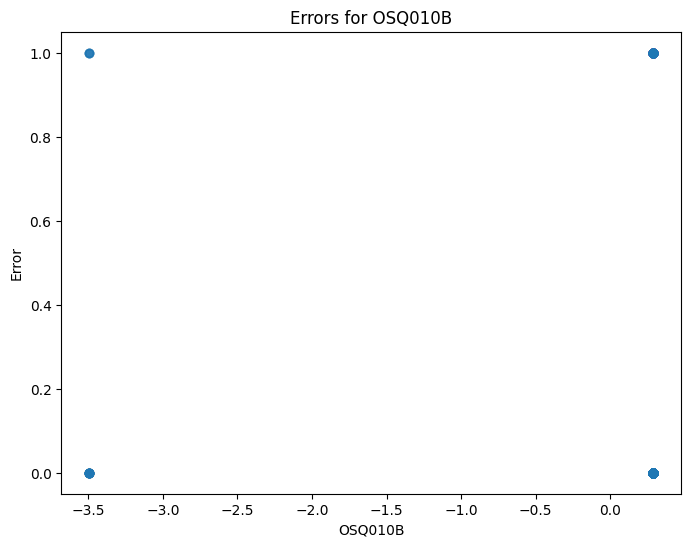

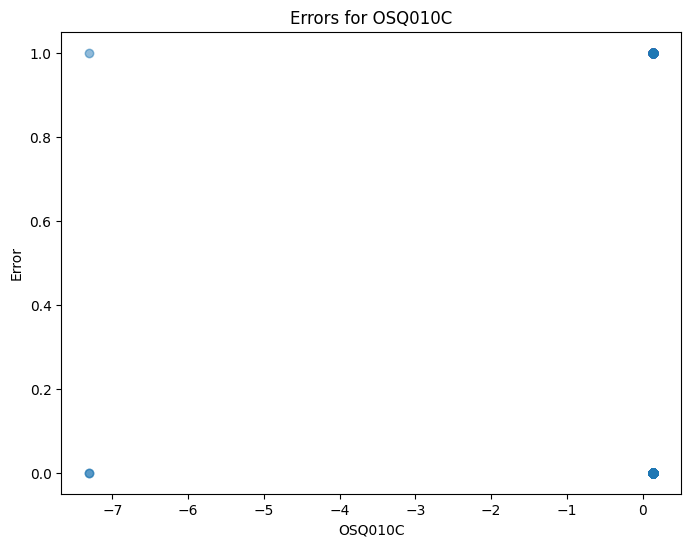

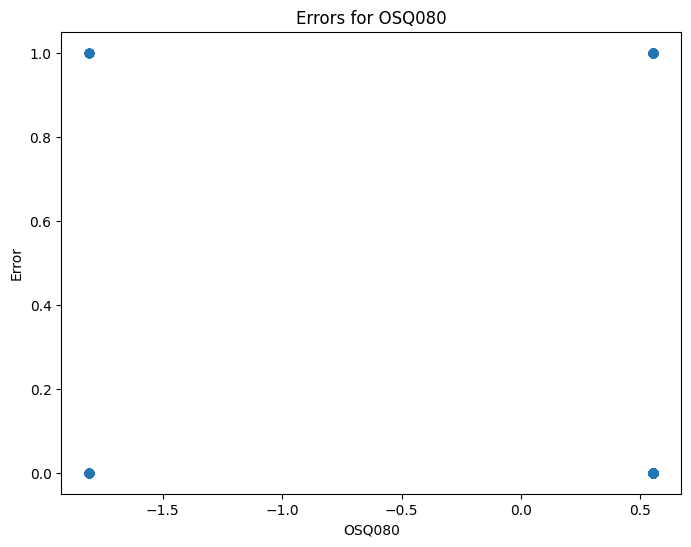

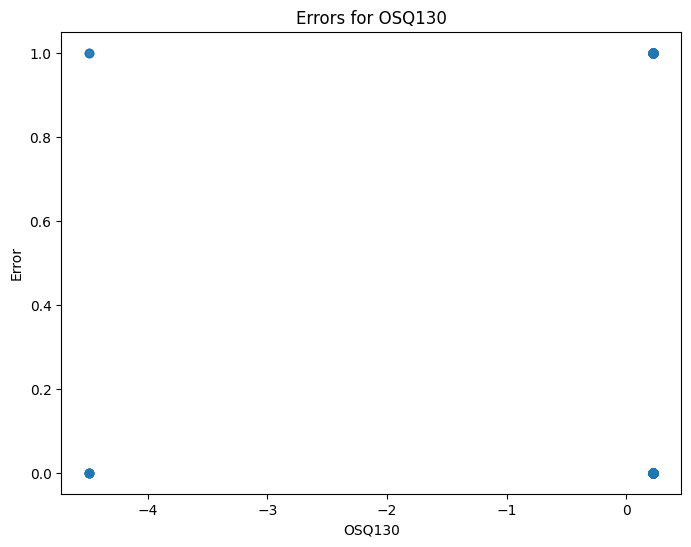

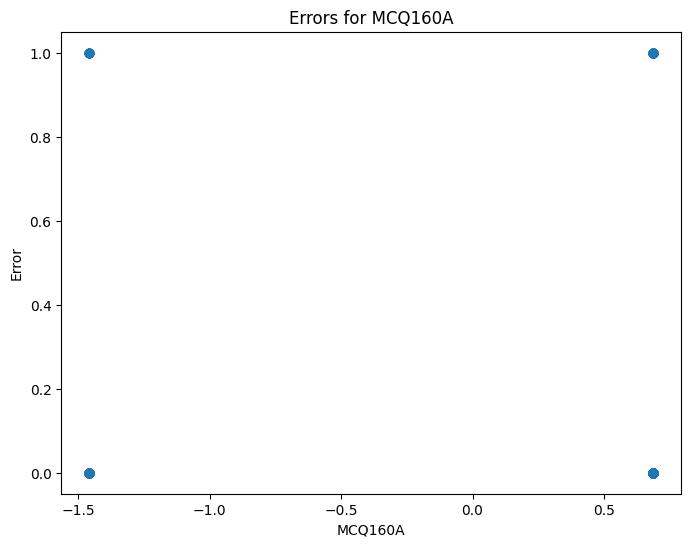

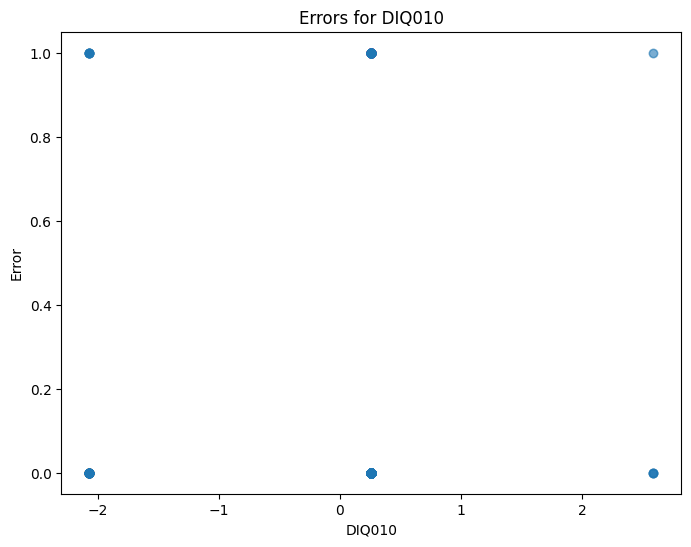


--------------------------------------------------------------------------------


In [29]:
models = [
    DecisionTreeClassifier(criterion='entropy', max_depth=4, min_weight_fraction_leaf=0.3), 
    RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50), 
    SVC(C=3.845401188473625, coef0=3.8028572256396647, gamma=0.9086840411922463, kernel='linear', shrinking=True), 
    LogisticRegression(C=0.1, max_iter=100, penalty='l1', solver='liblinear')
]

#models = [
#    DecisionTreeClassifier(), 
#    RandomForestClassifier(), 
#    SVC(), 
#    LogisticRegression()
#]

for model in models:
    print(f'{model.__class__.__name__}'.center(40, '-') + '\n')

    # 1. TRAIN THE MODEL
    model.fit(X_train, y_train)

    # 2. EVALUATE THE MODEL
    # 
    # a) Recall
    y_pred = model.predict(X_test)
    print(f'Recall: {(recall_score(y_test, y_pred)*100).round(1)}%')

    # b) Cross-validation: Use StratifiedKFold for cross-validation for each model
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    results = cross_val_score(model, X_train, y_train, cv=cv, scoring='recall')  # Using 'recall' for binary classification
    print(f"Cross-Validation Recall: %.1f%% (%.1f%%)" % (results.mean()*100.0, results.std()*100.0) + '\n')
    
    # c) Evaluate the model: Print classification report and confusion matrix for train and test
    print("TRAIN".center(50))
    train_classification_report = metrics_score(y_train, model.predict(X_train))
    print("TEST".center(50))
    test_classification_report = metrics_score(y_test, model.predict(X_test))

    # 3. OVERFITTING EVALUATION
    print(evaluate_overfitting(train_classification_report, test_classification_report)+ '\n')

    # 4. FEATURE IMPORTANCE
    #
    # a) SHAP values
    do_shap(model, X_train)

    # b) Model's coefficients and scores
    # Extract the importance scores for each feature from the model. Check if the model has a 'feature_importances_' attribute (like in tree-based models), or coef_attribute to gain insight about the relevance of each feature.
    if hasattr(model, 'feature_importances_'): # Check if the model provides feature_importances_ (like in trees)
        feature_importances = model.feature_importances_
    elif hasattr(model, 'coef_'): # For linear models like Logistic Regression or linear SVC
        # The .ravel() method converts a 2D array to 1D.
        feature_importances = np.abs(model.coef_.ravel())  # Use absolute values as importance

    # If we found some sort of importance values, display them
    if feature_importances is not None:

        # Get the indices that would sort the importance scores in descending order.
        indices = np.argsort(feature_importances)[::-1]

        # Print the feature ranking
        print("Feature ranking:")

        # Iterate through all features and print their rank, name, and importance score.
        for f in range(X_train.shape[1]):
            # Using X_train.columns to retrieve the feature name instead of its index for more descriptive information.
            print("%d. feature %s (%f)" % (f + 1, X_train.columns[indices[f]], feature_importances[indices[f]]))

        # Plot the feature importances for a visual representation.
        plt.figure(figsize=(12, 6))
        plt.title("Feature importances")
        # Create a bar chart of feature importances in descending order.
        plt.bar(range(X_train.shape[1]), feature_importances[indices],
                color="r", align="center")
        # Use the names of the features as x-tick labels and rotate them for better visibility.
        plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation='vertical')
        # Set the x-axis limits to include all features.
        plt.xlim([-1, X_train.shape[1]])
        # Adjust the layout of the plot to ensure that all labels fit inside the figure.
        plt.tight_layout()
        # Display the plot.
        plt.show()

    # 5. ERROR ANALYSIS
    #
    # a) Errors for different values of the input features
    plot_errors(X_test, y_test, y_pred, X_test.columns)
    # 2 kernel density functions: age in X axis. Y axis: PDF of getting error for each age. ALso joint PDF: X axis: age, Y axis: PDF error. (separated by sex)

    
    print('\n' + '-'*80)  # Just for better visual separation
    

#### Why Recall?

We want to detect most people who have low bone density, that is, having few false negatives, even if that means having more false positives. If you want to reduce false negatives (FN) to the minimum, even at the cost of increasing false positives (FP), you are primarily concerned with the recall (sensitivity) of the positive class (in this case, `TARGET_BINARY = 1`). 

Recall is defined as:

$$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP) + False Negatives (FN)}}
$$

A higher recall indicates fewer false negatives. In the context of your problem, a high recall would mean that most of the people who actually have low bone density are correctly identified by the model.

However, as you mentioned being willing to tolerate more false positives to achieve this, it's important to remember that there's often a trade-off between precision and recall. As recall increases, precision (the ability of the classifier not to label a negative sample as positive) might decrease.

In summary, the performance metric of most interest to you is **recall** for the positive class (`TARGET_BINARY = 1`).